# Optimal Control Problem

The problem then reduces to finding a pair $(\psi, u)$ that minimizes 
$$
J(\psi, u) = \frac{1}{2} \|\psi(\cdot,T) - \psi^\dagger \|_{L^2(R^d)}^2 + \frac{\nu}{2} \int_0^T \|u(t) \|_2^2 \, dt + \frac{\kappa}{2} \int_0^T \|\psi(\cdot,t) - \hat\psi \|_{L^2(R^d)}^2 \, dt,
$$
where $\psi^\dagger = U^{-1} \rho^\dagger$, subject to the controlled equation
$$
\partial_t \psi = - \mathcal{H} \psi + \sum_{i=1}^m u_i(t) \, \mathcal{N}_i \psi.
$$

In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import dblquad
from scipy.integrate import quad

from schorodinger_operator import WolframNDEigensystemApproximator
from schorodinger_operator import SchrodingerControlSolver
from schorodinger_operator import AnalyticSchrodingerApproximator

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

## Example 1: $V(x) = x^2/2$

We start with the simple example $V(x) = x^2 / 2$, which does not show good properties for our puorposes, but might be interesting. 

In [2]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="0.25*x^2-0.5",
    L=10.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.5}
)

def potential(x): return 0.5 * x**2

def rho_0(x):
    return np.exp(-(x + 2.0)**2 / 2) / np.sqrt(2*np.pi)

def rho_dag(x):
    return np.exp(-x**2 / 2 ) / np.sqrt(2*np.pi)

def nabla_alpha(x):
    return np.ones_like(x)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=rho_dag,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: x,
    correct_lambda0=True
)

T = 1.0
result_control = solver.solve(T=T, max_iter=500, tol=1e-6, time_eval=np.linspace(0, T, 501), verbose=True, 
                              learning_rate_kwargs={'gamma': 5, 'method': "bb"}, inicialization=True)

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 501), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 1.861e+01, gamma = 5
Iteration 2: ||grad|| = 1.586e+03, gamma = 0.05800567382324146
Iteration 3: ||grad|| = 1.702e+01, gamma = 0.057389862932456306
Iteration 4: ||grad|| = 1.569e+01, gamma = 0.7363258336184909
Iteration 5: ||grad|| = 5.539e+00, gamma = 1.1381494487103636
Iteration 6: ||grad|| = 2.272e+00, gamma = 1.9298358536866238
Iteration 7: ||grad|| = 3.250e-01, gamma = 2.251888769813736
Iteration 8: ||grad|| = 8.370e-03, gamma = 2.3114211851621675
Iteration 9: ||grad|| = 4.179e-06, gamma = 2.312575306739891
Iteration 10: ||grad|| = 1.102e-07, gamma = 2.31264914981918


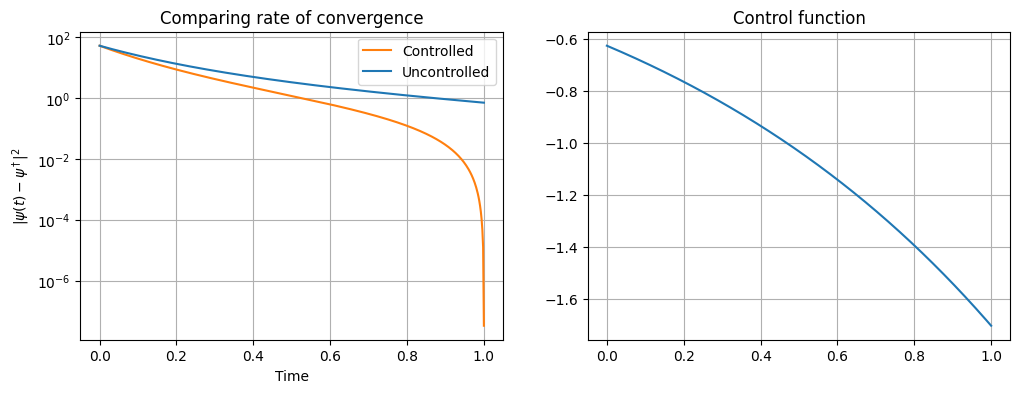

In [3]:
time_grid = result['time']
u_vals = result_control['u_vals'][:, 0]

diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_grid, diff_control, label='Controlled', color='C1')
ax[0].plot(time_grid, diff_nocontrol, label='Uncontrolled', color='C0')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(time_grid, u_vals)
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

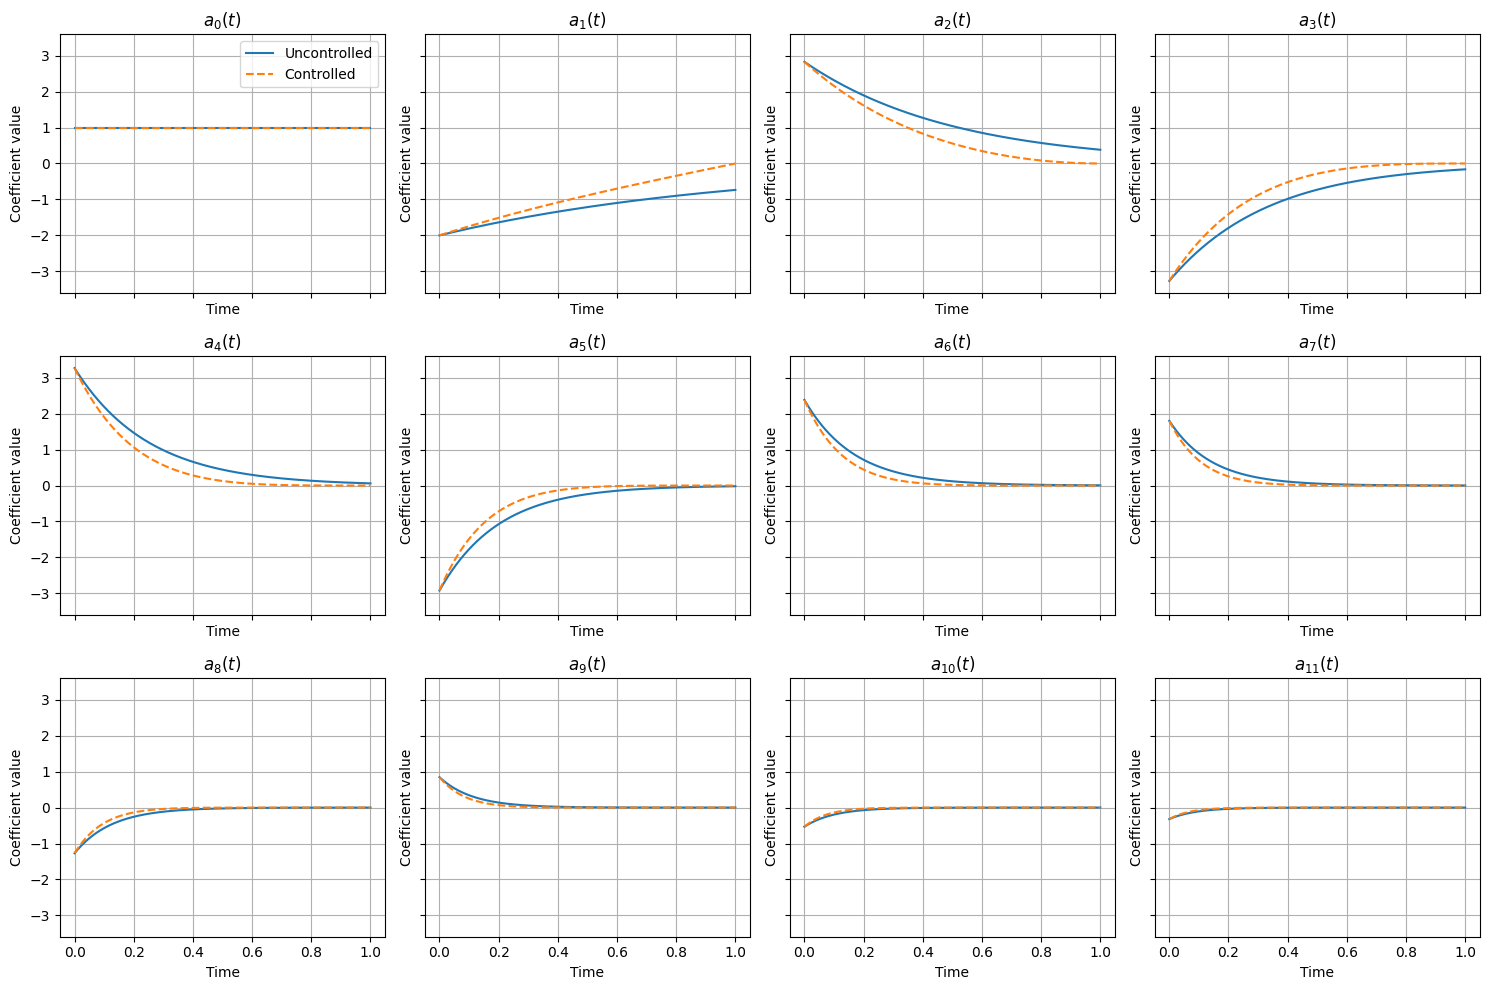

In [4]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(time_grid, result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(time_grid, result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example: $V(x) = \log(1+x^2)$

In [10]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="(2*x^2-1)/(1+x^2)^2",
    L=10.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.5}
)

def potential(x): return np.log(1+x*x)

def rho_0(x):
    return np.exp(-(x + 2.0)**2 / 2) / np.sqrt(2*np.pi)

def rho_dag(x):
    return np.exp(-x**2 / 2 ) / np.sqrt(2*np.pi)

def nabla_alpha(x):
    return np.ones_like(x)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-4,
    kappa=5.0,
    nabla_alpha_list=None,
    nabla_V=lambda x: 2*x/(1+x*x),
    correct_lambda0=True,
    compute_alpha=2
)

T = 1.0
result_control = solver.solve(T=T, max_iter=500, tol=1e-6, time_eval=np.linspace(0, T, 501), verbose=True, 
                              learning_rate_kwargs={'gamma': 0.05, 'method': "bb"}, inicialization=True)

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 501), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 2.054e+01, gamma = 0.05
Iteration 2: ||grad|| = 6.542e+00, gamma = 0.043026686267865294
Iteration 3: ||grad|| = 1.818e+00, gamma = 0.06048171934367487
Iteration 4: ||grad|| = 1.332e+00, gamma = 0.23099072311941898
Iteration 5: ||grad|| = 7.555e-01, gamma = 0.5606255635285725
Iteration 6: ||grad|| = 2.365e-01, gamma = 0.859922396336408
Iteration 7: ||grad|| = 2.590e-01, gamma = 0.2633883000451242
Iteration 8: ||grad|| = 1.322e-01, gamma = 0.21167255801345136
Iteration 9: ||grad|| = 1.105e-01, gamma = 0.8044236175394043
Iteration 10: ||grad|| = 8.743e-02, gamma = 0.4746002083958052
Iteration 11: ||grad|| = 3.097e-02, gamma = 0.3608397346880382
Iteration 12: ||grad|| = 5.135e-02, gamma = 0.24867000122110455
Iteration 13: ||grad|| = 5.137e-03, gamma = 0.16847316672902424
Iteration 14: ||grad|| = 3.101e-02, gamma = 0.179138217400861
Iteration 15: ||grad|| = 3.013e-02, gamma = 0.7343888377019095
Iteration 16: ||grad|| = 4.735e-02, ga

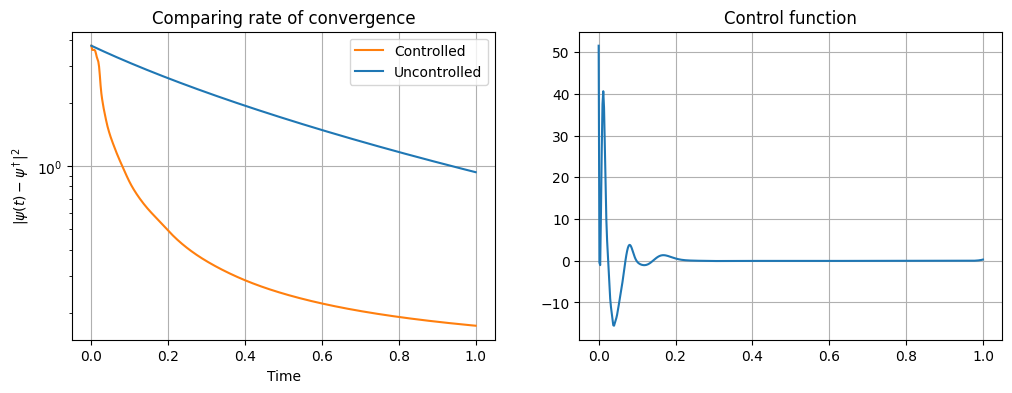

In [11]:
time_grid = result['time']
u_vals = result_control['u_vals'][:, 0]

diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_grid, diff_control, label='Controlled', color='C1')
ax[0].plot(time_grid, diff_nocontrol, label='Uncontrolled', color='C0')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(time_grid, u_vals)
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

## Example 2: $V(x) = (x^2 - 1.5)^2$

In this example, I chose $\alpha$ "smartly".

In [34]:
x = sp.symbols('x')
potential = (x**2 - 1.5)**2

potential_prime = sp.diff(potential, x)
potential_double_prime = sp.diff(potential_prime, x)

expression = 0.25 * potential_prime**2 - 0.5 * potential_double_prime
print(potential_prime.simplify())
print(expression.simplify())

x*(4.0*x**2 - 6.0)
4.0*x**6 - 12.0*x**4 + 3.0*x**2 + 3.0


In [52]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver1 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=1.0,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

solver2 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=0.0,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control1 = solver1.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                               )
result_control2 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=False,
                                control_funcs=[lambda t: np.interp(t, np.linspace(0, T, 501), solver1.u_initial.flatten())]
                                )

result_control3 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                                )

result = solver.solve(T=T, max_iter=200, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 8.219e-01, gamma = 10
Iteration 2: ||grad|| = 7.450e-01, gamma = 92.07366322332557
Iteration 3: ||grad|| = 3.166e-01, gamma = 66.15314961914719
Iteration 4: ||grad|| = 1.184e-01, gamma = 56.42194607042666
Iteration 5: ||grad|| = 7.678e-02, gamma = 69.1893535380594
Iteration 6: ||grad|| = 6.258e-02, gamma = 194.75220923109458
Iteration 7: ||grad|| = 4.287e-02, gamma = 255.19785584099697
Iteration 8: ||grad|| = 4.120e-02, gamma = 141.50132492704597
Iteration 9: ||grad|| = 5.487e-02, gamma = 52.91701327548138
Iteration 10: ||grad|| = 2.846e-02, gamma = 47.91928232016407
Iteration 11: ||grad|| = 2.712e-02, gamma = 76.23520027324255
Iteration 12: ||grad|| = 2.597e-02, gamma = 1107.535952993496
Iteration 13: ||grad|| = 1.886e-02, gamma = 899.2082286325557
Iteration 14: ||grad|| = 1.336e-01, gamma = 63.58292738412453
Iteration 15: ||grad|| = 1.508e-02, gamma = 64.0644036133578
Iteration 16: ||grad|| = 1.367e-02, gamma = 89.26202461608

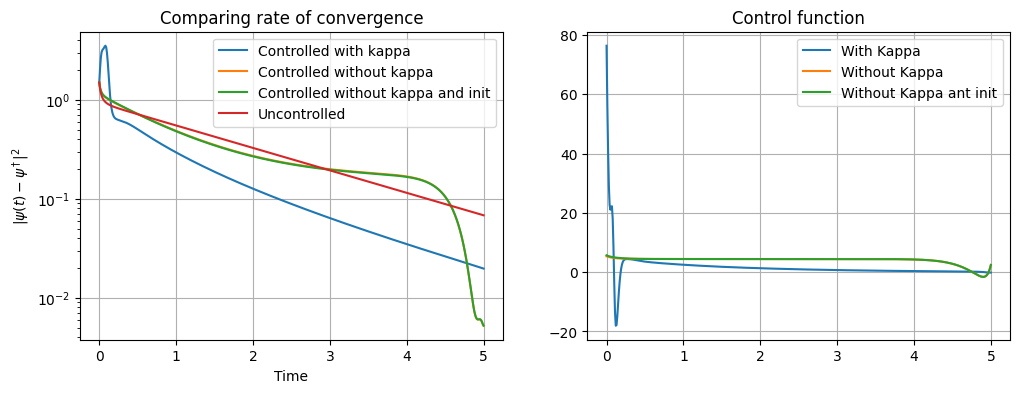

In [54]:
diff_control1 = np.trapezoid((result_control1['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)
diff_control2 = np.trapezoid((result_control2['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_control3 = np.trapezoid((result_control3['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control1['time'], diff_control1, label='Controlled with kappa')
ax[0].plot(result_control2['time'], diff_control2, label='Controlled without kappa')
ax[0].plot(result_control3['time'], diff_control3, label='Controlled without kappa and init')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control1['time'], result_control1['u_vals'][:, 0], label="With Kappa")
ax[1].plot(result_control2['time'], result_control2['u_vals'][:, 0], label="Without Kappa")
ax[1].plot(result_control3['time'], result_control3['u_vals'][:, 0], label="Without Kappa ant init")
ax[1].legend()
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

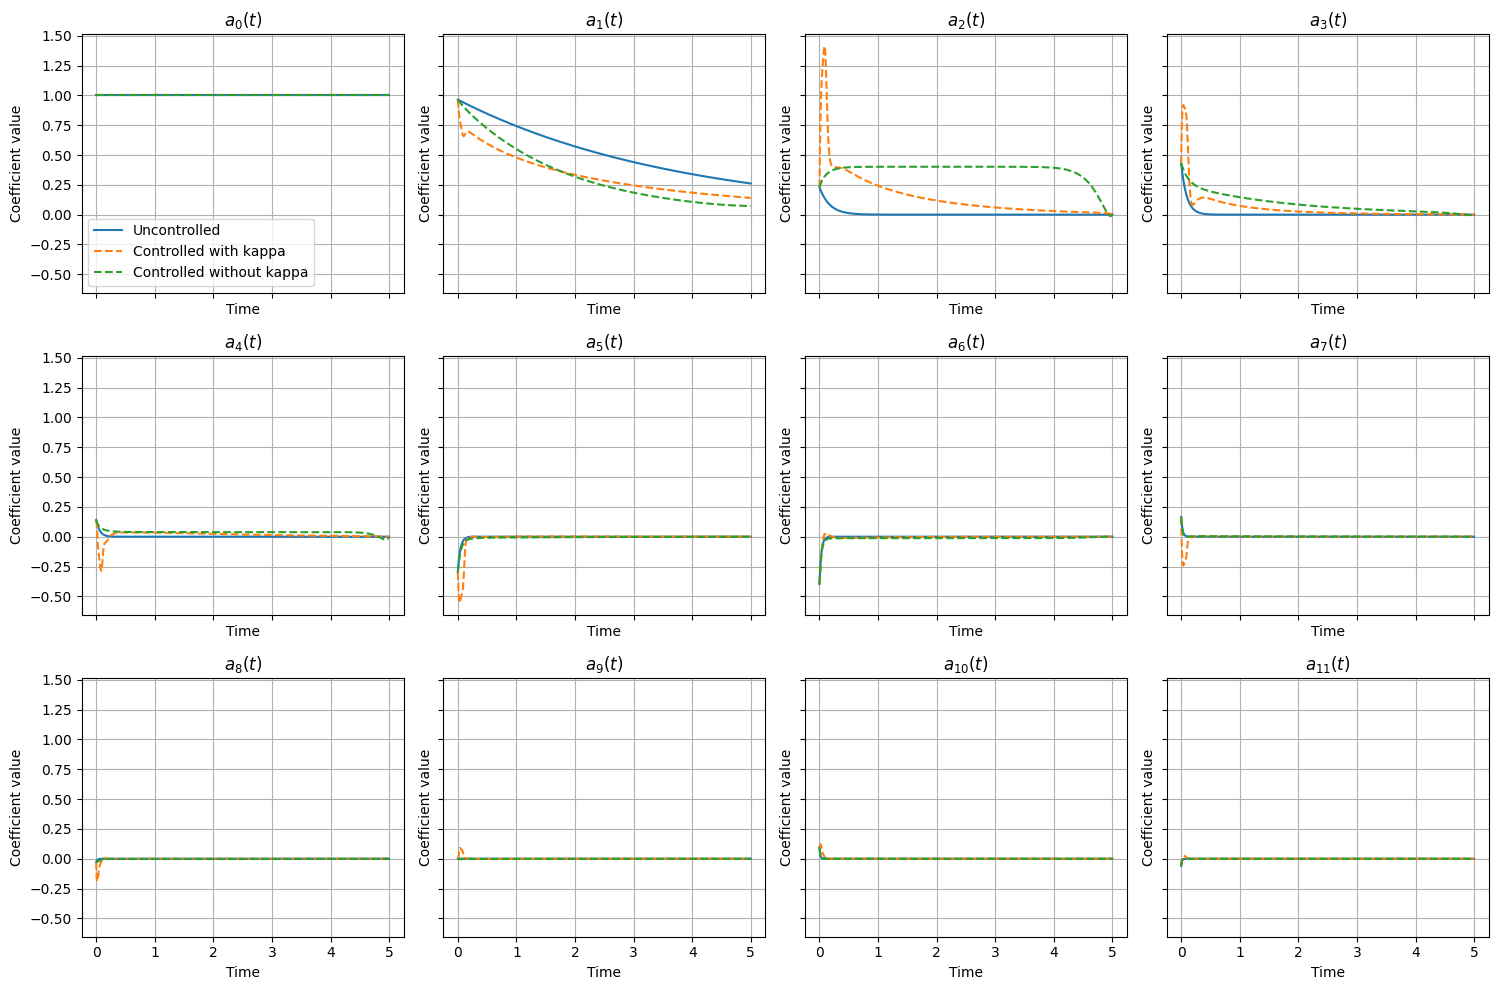

In [58]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control1['a_vals'][:, i], label='Controlled with kappa', color='C1', linestyle='--')
    ax.plot(result_control['time'], result_control2['a_vals'][:, i], label='Controlled without kappa', color='C2', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

### Observing matrix N

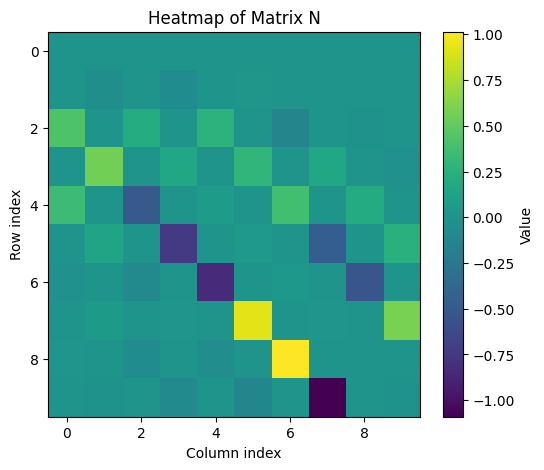

In [64]:
plt.figure(figsize=(6, 5))
plt.imshow(solver1.Delta[0][:10,:10], cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Heatmap of Matrix N')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.show()

## Example 3: including more controls

Let us include one more control in the same example as before. 

In [93]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=5000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y

nabla_alpha_list = [lambda x: np.sin(0.5*x)/(1 + x**4), # similar to e_1
                    lambda x: (1 - x**2) * np.exp(-x**2 / 2)] # similar to e_2

solver1 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=1.0,
    nu=1e-4,
    const=1.0,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

solver2 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=0.0,
    nu=1e-4,
    const=1.0,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control1 = solver1.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                               )

result_control2 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=False,
                                control_funcs=[lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 1].flatten()), 
                                              ]
                                )

result_control3 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                                )

result = solver1.solve(T=T, max_iter=200, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 1.424e-01, gamma = 10
Iteration 2: ||grad|| = 6.909e-02, gamma = 15.628016214135265
Iteration 3: ||grad|| = 3.690e-02, gamma = 29.490266658663565
Iteration 4: ||grad|| = 1.691e-02, gamma = 36.961251694634186
Iteration 5: ||grad|| = 1.247e-02, gamma = 46.72900499333619
Iteration 6: ||grad|| = 2.077e-02, gamma = 11.592163271221649
Iteration 7: ||grad|| = 1.129e-02, gamma = 8.394578457414317
Iteration 8: ||grad|| = 8.327e-03, gamma = 8.794728591182842
Iteration 9: ||grad|| = 8.068e-03, gamma = 175.86760438631677
Iteration 10: ||grad|| = 4.891e-03, gamma = 182.2466833823609
Iteration 11: ||grad|| = 2.560e-02, gamma = 11.277981275561334
Iteration 12: ||grad|| = 1.047e-02, gamma = 8.43254105232328
Iteration 13: ||grad|| = 4.514e-03, gamma = 8.695644265202336
Iteration 14: ||grad|| = 3.949e-03, gamma = 27.43583526246889
Iteration 15: ||grad|| = 3.313e-03, gamma = 30.200953445728743
Iteration 16: ||grad|| = 3.155e-03, gamma = 110.14966

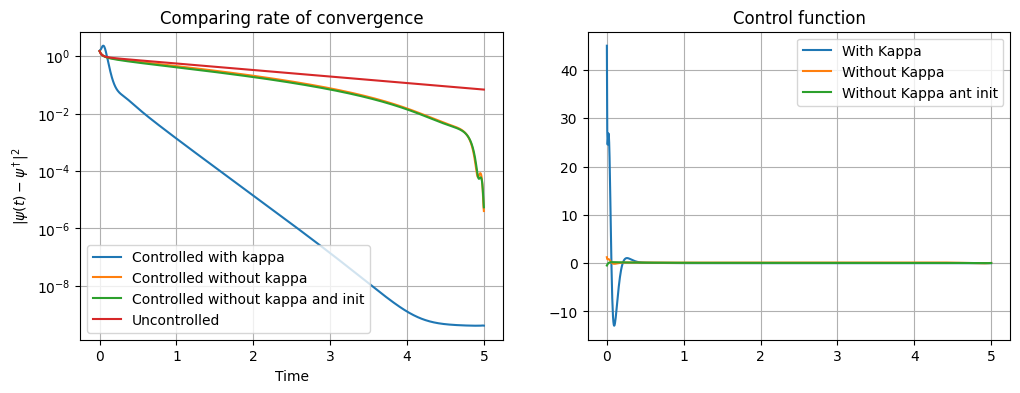

In [94]:
diff_control1 = np.trapezoid((result_control1['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)
diff_control2 = np.trapezoid((result_control2['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_control3 = np.trapezoid((result_control3['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control1['time'], diff_control1, label='Controlled with kappa')
ax[0].plot(result_control2['time'], diff_control2, label='Controlled without kappa')
ax[0].plot(result_control3['time'], diff_control3, label='Controlled without kappa and init')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control1['time'], result_control1['u_vals'][:, 0], label="With Kappa")
ax[1].plot(result_control2['time'], result_control2['u_vals'][:, 0], label="Without Kappa")
ax[1].plot(result_control3['time'], result_control3['u_vals'][:, 0], label="Without Kappa ant init")
ax[1].legend()
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

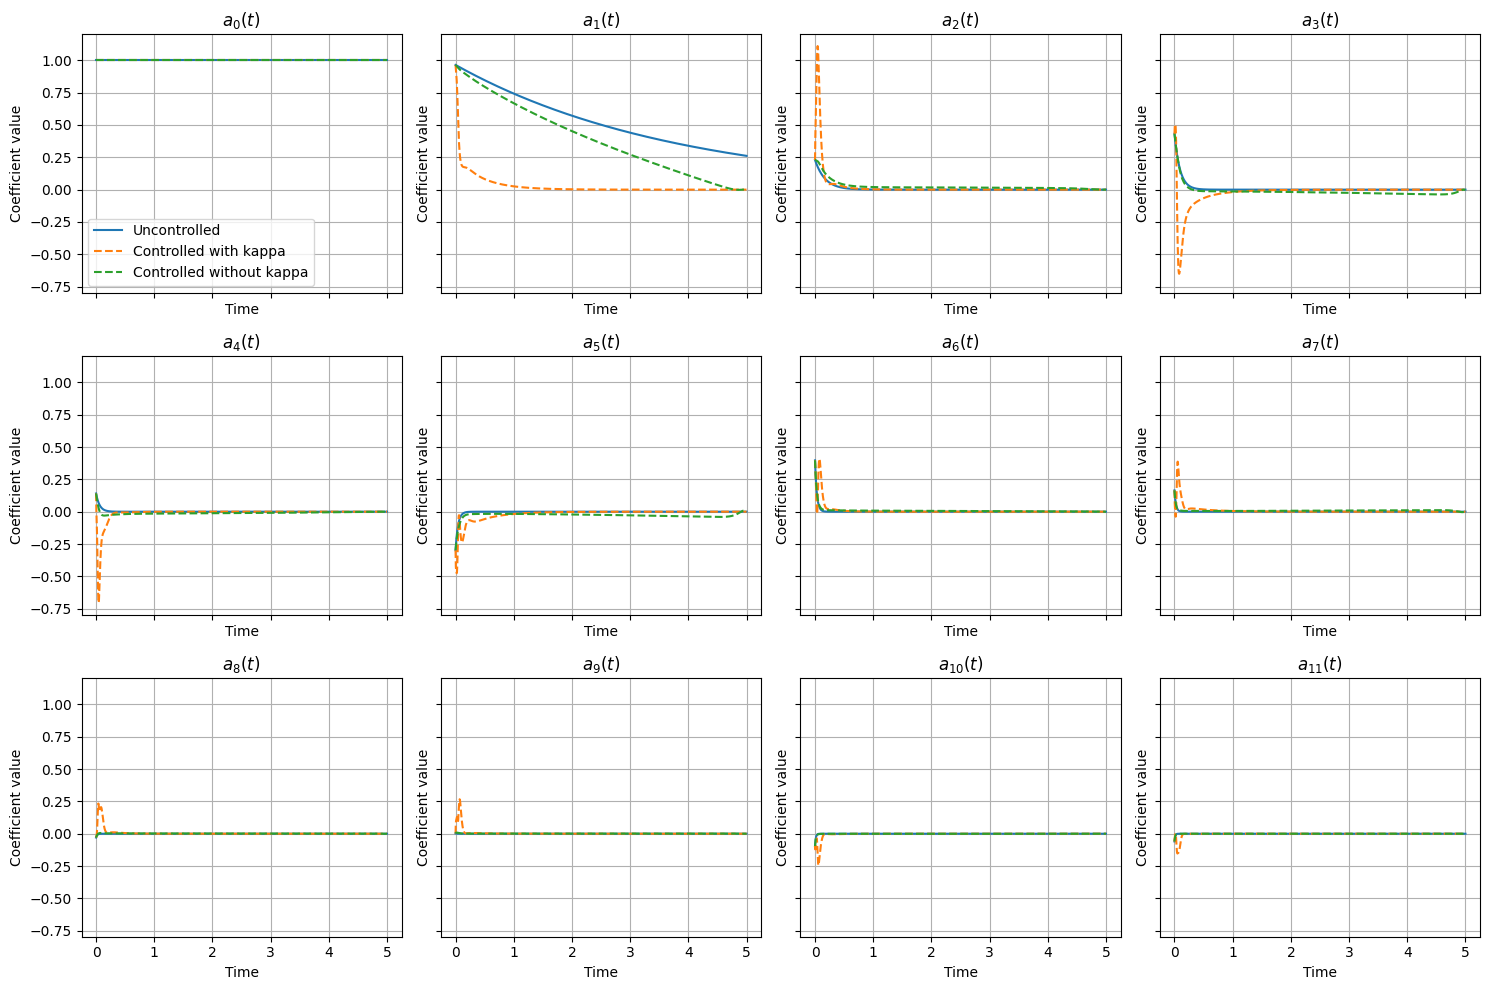

In [96]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control1['time'], result_control1['a_vals'][:, i], label='Controlled with kappa', color='C1', linestyle='--')
    ax.plot(result_control2['time'], result_control2['a_vals'][:, i], label='Controlled without kappa', color='C2', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [98]:
solver1.compute_cost_functional([lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 1].flatten()), 
                                ], T, np.linspace(0, T, 1001))

[np.float64(2.8439179241580788e-11),
 np.float64(0.003084772319319296),
 np.float64(0.11146240158837388)]

In [99]:
solver2.compute_cost_functional([lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 1].flatten()), 
                                ], T, np.linspace(0, T, 1001))

[np.float64(2.8439179241580788e-11),
 np.float64(0.003084772319319296),
 np.float64(0.0)]

In [100]:
solver2.compute_cost_functional([lambda t: np.interp(t, np.linspace(0, T, 1001), result_control3['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control3['u_vals'][:, 1].flatten()), 
                                ], T, np.linspace(0, T, 1001))

[np.float64(2.7318393482044715e-06),
 np.float64(0.00011114933200899273),
 np.float64(0.0)]

## Example 4: Multi-stable in 2d. Here the algorithm does work nicely.

Extend a one-dimensional Schrödinger control solver to two dimensions by designing a multi-stable potential $V(x,y)$ (e.g., a separable double-well potential $(x^2-1.5)^2 + (y^2-1.5)^2$)

In [108]:
x, y = sp.symbols('x y')
potential_sym = (x**2 - 1.5)**2 + (y**2 - 1.5)**2

potential_x = sp.diff(potential_sym, x)
potential_y = sp.diff(potential_sym, y)
laplace_V = sp.diff(potential_sym, x, 2) + sp.diff(potential_sym, y, 2)
gradV_sq = potential_x**2 + potential_y**2
expression_2d = 0.25 * gradV_sq - 0.5 * laplace_V

print("Gradient components:")
print("dV/dx =", sp.simplify(potential_x))
print("dV/dy =", sp.simplify(potential_y))
print("W =", sp.simplify(expression_2d))

Gradient components:
dV/dx = x*(4.0*x**2 - 6.0)
dV/dy = y*(4.0*y**2 - 6.0)
W = 4.0*x**6 - 12.0*x**4 + 3.0*x**2 + 4.0*y**6 - 12.0*y**4 + 3.0*y**2 + 6.0


In [178]:
potential_expr_str = "4*x^6-12*x^4+3*x^2+4*y^6-12*y^4+3*y^2+6"
approximator = WolframNDEigensystemApproximator(
    potential_expr=potential_expr_str,
    L=(3.0,3.0),
    N=500,
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

In [179]:
def potential(X, Y):
    return (X**2 - 1.5)**2 + (Y**2 - 1.5)**2

def integrand(r):
    return r * np.exp(-1/(1 - r**2))

integral_value, _ = quad(integrand, 0, 1.0)
C = 1 / (2 * np.pi * integral_value)

def rho_0(X, Y):
    r2 = X**2 + Y**2
    out = np.zeros_like(r2)
    mask = r2 < 1.0
    out[mask] = C * np.exp(-1 / (1 - r2[mask]))
    return out

nabla_alpha_list = [lambda X, Y: (np.ones_like(X), np.ones_like(Y))]
nabla_V = lambda X, Y: (4*(X**2 - 1.5)*X, 4*(Y**2 - 1.5)*Y)

solver2d = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=1.0,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=nabla_V,
    correct_lambda0=True
)

In [181]:
T = 5.0
result_control = solver2d.solve(
    T=T, 
    max_iter=500, 
    tol=1e-10, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    learning_rate_kwargs={'method': 'bb', 'gamma': 10}, 
    inicialization=True
)

result = solver2d.solve(
    T=T, 
    max_iter=200, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    control_funcs=[lambda t: np.zeros_like(t)], 
    optimise=False
)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 9.708e-08, gamma = 10
Iteration 2: ||grad|| = 1.209e-06, gamma = 0.736755660616634
Iteration 3: ||grad|| = 4.166e-08, gamma = 0.7288894937885572
Iteration 4: ||grad|| = 1.960e-08, gamma = 10
Iteration 5: ||grad|| = 6.960e-08, gamma = 1.773848982567569
Iteration 6: ||grad|| = 6.114e-08, gamma = 10
Iteration 7: ||grad|| = 5.647e-07, gamma = 0.8612358048235714
Iteration 8: ||grad|| = 1.716e-07, gamma = 0.7825775303129004
Iteration 9: ||grad|| = 9.102e-08, gamma = 1.428050972833961
Iteration 10: ||grad|| = 5.018e-08, gamma = 10
Iteration 11: ||grad|| = 2.245e-07, gamma = 1.2617637692099326
Iteration 12: ||grad|| = 1.464e-07, gamma = 0.9270187616231028
Iteration 13: ||grad|| = 7.710e-08, gamma = 0.8426769807173751
Iteration 14: ||grad|| = 1.062e-07, gamma = 0.22204070483429394
Iteration 15: ||grad|| = 8.415e-08, gamma = 10
Iteration 16: ||grad|| = 2.878e-07, gamma = 1.0897159673576235
Iteration 17: ||grad|| = 1.401e-07, gamma = 1.11

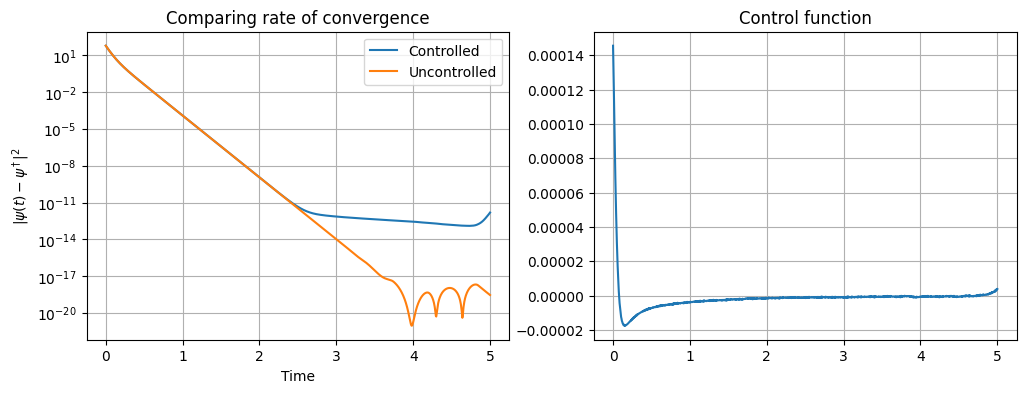

In [191]:
diff_control = np.sum((result_control['a_vals'] - solver2d.a_dag)**2, axis=1)
diff_nocontrol = np.sum((result['a_vals'] - solver2d.a_dag)**2, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

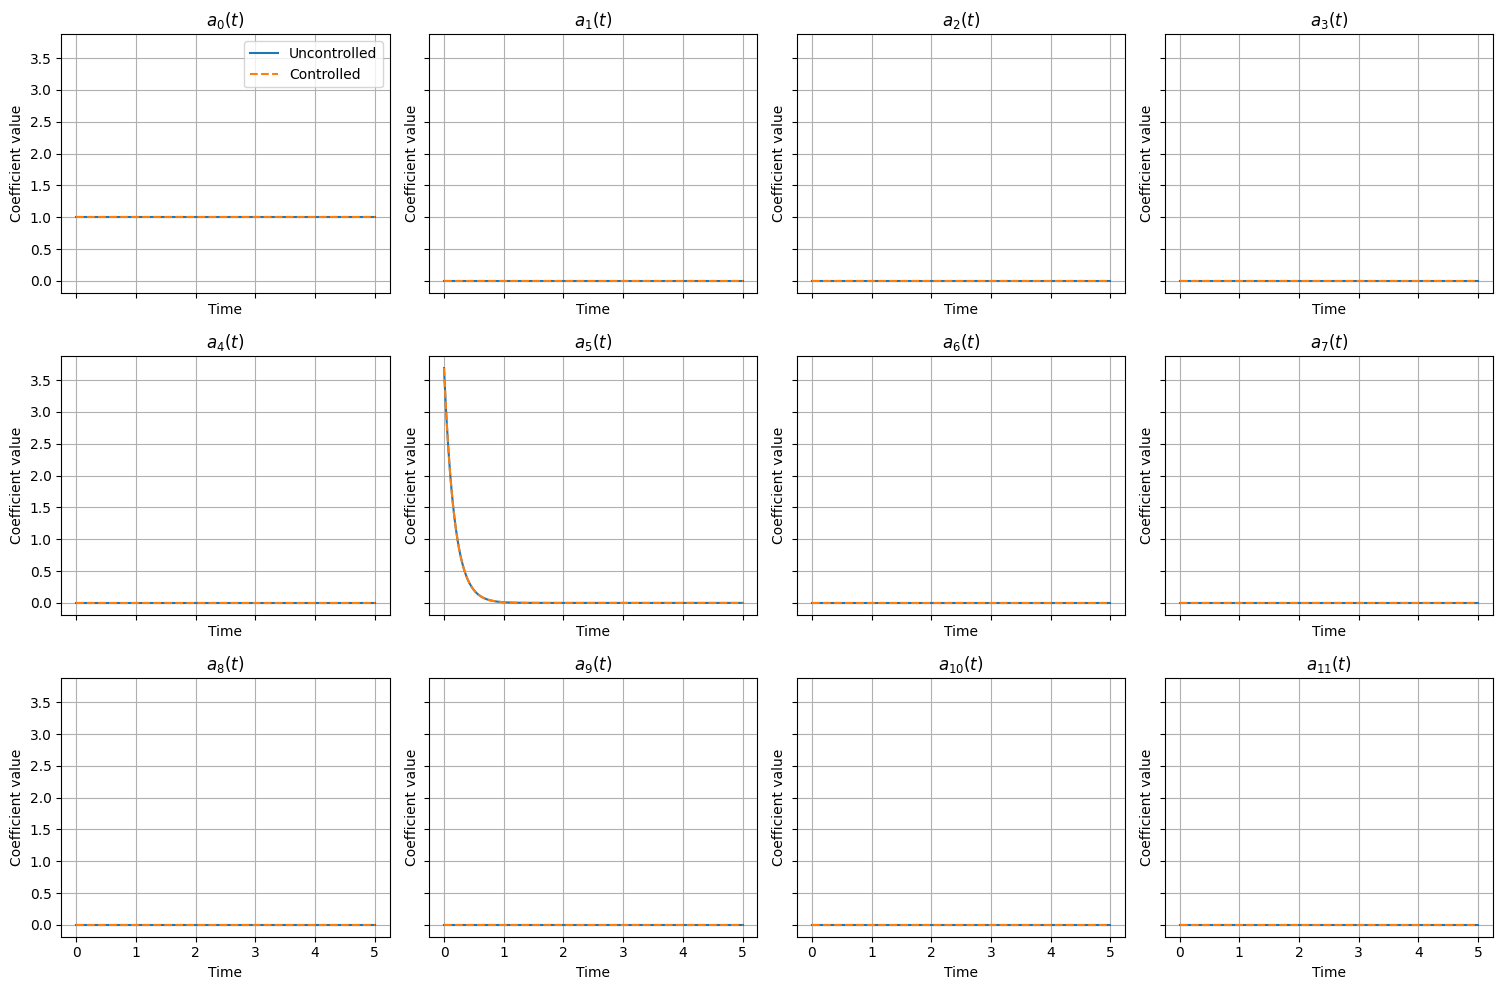

In [193]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control1['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 5: Multi-stable in 2d. Here we want to take a_1(0) different then 0.

In [2]:
potential_expr_str = "4*x^6-12*x^4+3*x^2+4*y^6-12*y^4+3*y^2+6"
approximator = WolframNDEigensystemApproximator(
    potential_expr=potential_expr_str,
    L=(3.0,3.0),
    N=(500, 500),
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

eigeninfo = approximator.solve_eigen(num_eigen=50, derivative=True)

In [5]:
def potential(X, Y):
    return (X**2 - 1.5)**2 + (Y**2 - 1.5)**2

def integrand(r):
    return r * np.exp(-1 / (1 - r**2 / 4))

integral_value, _ = quad(integrand, 0, 2)
C = 1 / (2 * np.pi * integral_value)

def rho_0(X, Y):
    r2 = (X + 0.2)**2 + (Y - 0.5)**2  # Shift the center to (0.5, 0.5)
    out = np.zeros_like(r2)
    mask = r2 < 4  # Ensure the support remains within r < 2
    out[mask] = C * np.exp(-1 / (1 - r2[mask] / 4))
    return out

nabla_alpha_list = [lambda X, Y: (np.ones_like(X), np.ones_like(Y))]
nabla_V = lambda X, Y: (4*(X**2 - 1.5)*X, 4*(Y**2 - 1.5)*Y)

solver2d = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=5.0,
    nu=1e-4,
    nabla_alpha_list=None,
    nabla_V=nabla_V,
    correct_lambda0=True,
    eigeninfo=eigeninfo,
    compute_alpha=2
)

In [7]:
T = 5.0
result_control = solver2d.solve(
    T=T, 
    max_iter=500, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    learning_rate_kwargs={'method': 'bb', 'gamma': 1}, 
    inicialization=True
)

result = solver2d.solve(
    T=T, 
    max_iter=200, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    control_funcs=[lambda t: np.zeros_like(t)], 
    optimise=False
)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 2.628e+00, gamma = 1
Iteration 2: ||grad|| = 2.285e+00, gamma = 0.5368601032283927
Iteration 3: ||grad|| = 2.943e-01, gamma = 0.4888744900150622
Iteration 4: ||grad|| = 1.238e-01, gamma = 0.5121401625251482
Iteration 5: ||grad|| = 1.061e-01, gamma = 2.177153600912867
Iteration 6: ||grad|| = 7.057e-02, gamma = 2.480655526457309
Iteration 7: ||grad|| = 6.217e-02, gamma = 5.437626786394311
Iteration 8: ||grad|| = 9.649e-02, gamma = 1.2162930061088253
Iteration 9: ||grad|| = 1.186e-01, gamma = 0.5324660640982003
Iteration 10: ||grad|| = 4.285e-02, gamma = 0.5591994685594893
Iteration 11: ||grad|| = 4.164e-02, gamma = 1.8615392435162212
Iteration 12: ||grad|| = 3.891e-02, gamma = 18.27268749877176
Iteration 13: ||grad|| = 4.256e-02, gamma = 7.883324367544028
Iteration 14: ||grad|| = 5.646e-01, gamma = 0.4804353615050884
Iteration 15: ||grad|| = 2.091e-02, gamma = 0.47726673258218605
Iteration 16: ||grad|| = 1.855e-02, gamma = 0.6896

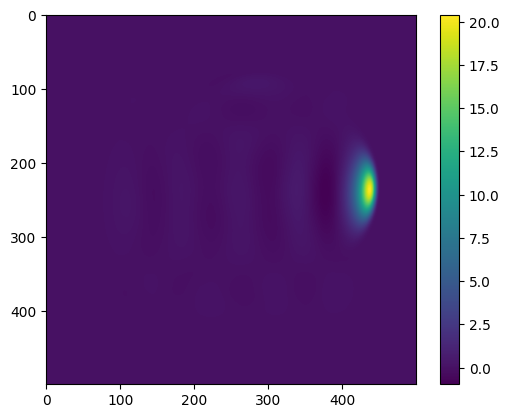

In [8]:
X, Y = np.meshgrid(solver2d.x, solver2d.y, indexing='ij') 
fig = plt.figure()
im = plt.imshow(rho_0(X, Y) / np.sqrt(solver2d.rho_infty(X,Y)) - result['psi'][0])
fig.colorbar(im)

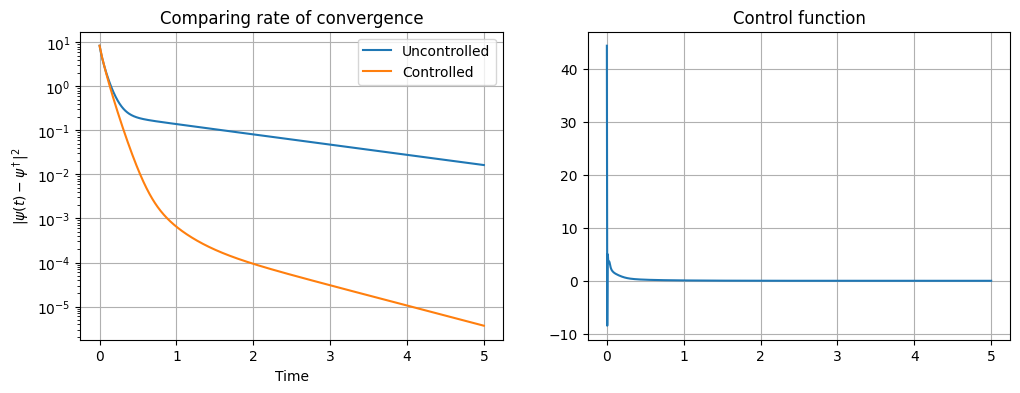

In [9]:
diff_control = np.sum((result_control['a_vals'] - solver2d.a_dag)**2, axis=1)
diff_nocontrol = np.sum((result['a_vals'] - solver2d.a_dag)**2, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')
ax[0].plot(result_control['time'], diff_control, label='Controlled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

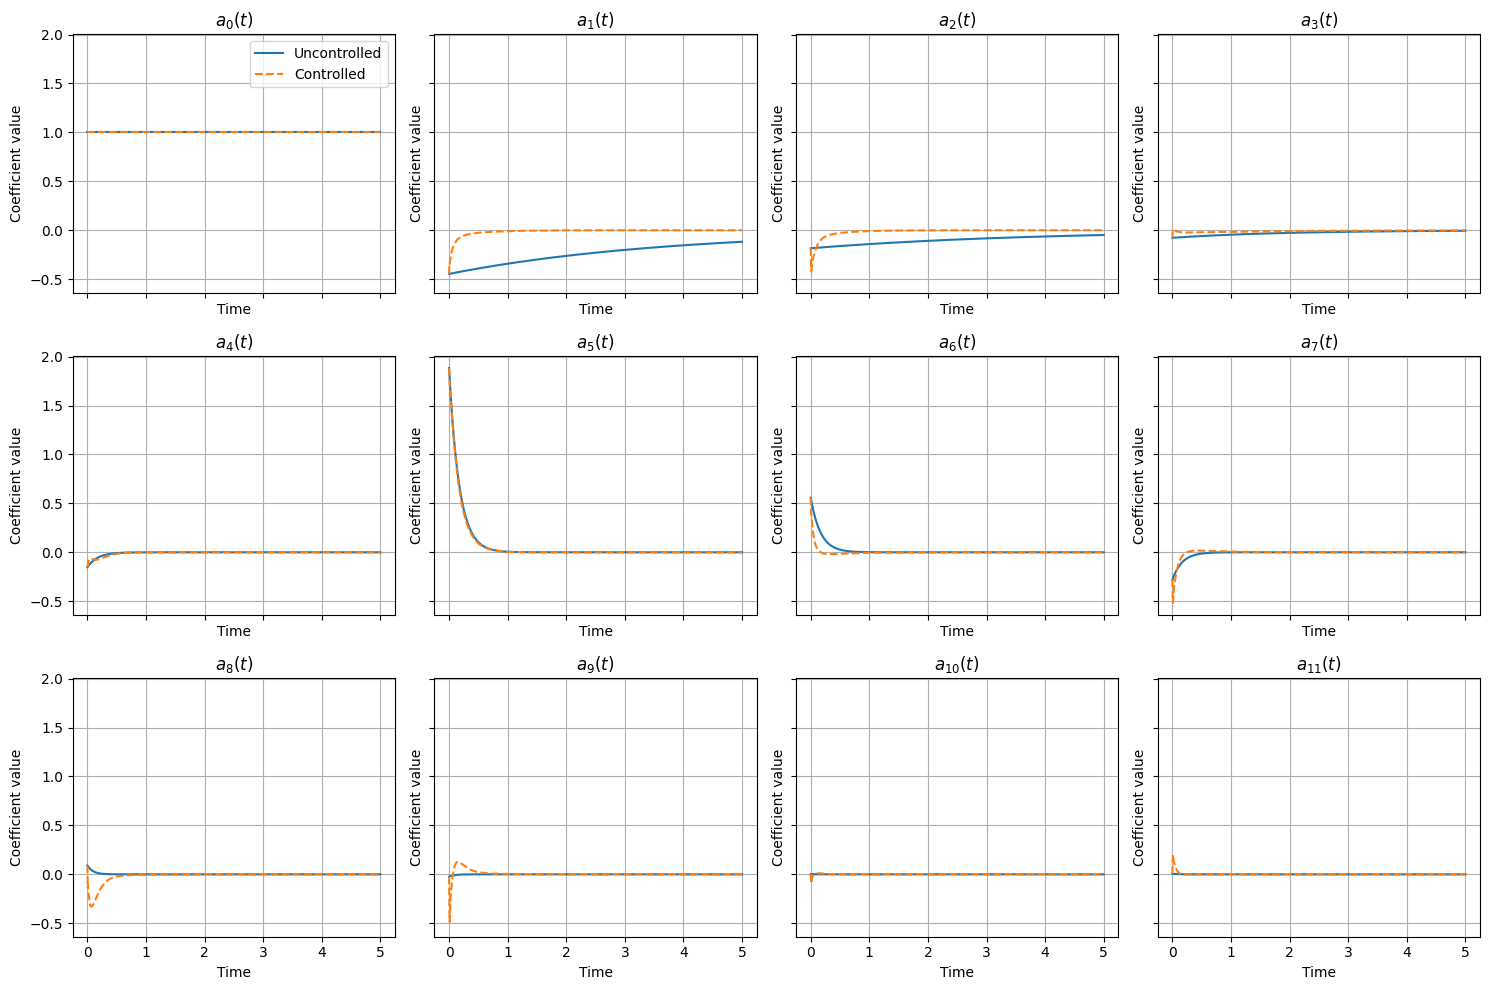

In [11]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 6: Normal distribution example.

In [3]:
a, b, x, y = sp.symbols('a b x y')
potential_sym = 0.5 * (a*x**2 + b*y**2)

potential_x = sp.diff(potential_sym, x)
potential_y = sp.diff(potential_sym, y)
laplace_V = sp.diff(potential_sym, x, 2) + sp.diff(potential_sym, y, 2)
gradV_sq = potential_x**2 + potential_y**2
expression_2d = 0.25 * gradV_sq - 0.5 * laplace_V

print("Gradient components:")
print("dV/dx =", sp.simplify(potential_x))
print("dV/dy =", sp.simplify(potential_y))
print("W =", sp.simplify(expression_2d))

Gradient components:
dV/dx = 1.0*a*x
dV/dy = 1.0*b*y
W = 0.25*a**2*x**2 - 0.5*a + 0.25*b**2*y**2 - 0.5*b


In [4]:
a_value = 1
b_value = 0.1

def potential(X, Y):
    return 0.5 * (a_value*X*X + b_value*Y*Y)

In [5]:
approximator_normal = AnalyticSchrodingerApproximator(
    L=(3.0, 15.0),
    N=(500, 500),
    sigma=1.0,
    a=a_value,
    b=b_value,
)

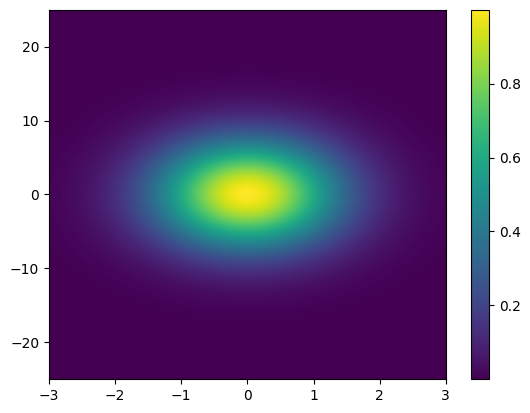

In [6]:
X, Y = np.meshgrid(approximator_normal.x, approximator_normal.y, indexing='ij')

fig = plt.figure()
im = plt.imshow(np.exp(-potential(X, Y)).T, origin='lower', extent=[-3, 3, -25, 25], aspect='auto')
fig.colorbar(im)
plt.show()

In [7]:
eigeninfo_normal = approximator_normal.solve_eigen(num_eigen=50, derivative=True)

In [8]:
def integrand(r):
    return r * np.exp(-1 / (1 - r**2 / 4))

integral_value, _ = quad(integrand, 0, 2)
C = 1 / (2 * np.pi * integral_value)

def rho_0(X, Y):
    r2 = (X + 0.2)**2 + (Y - 0.5)**2  # Shift the center to (0.5, 0.5)
    out = np.zeros_like(r2)
    mask = r2 < 4  # Ensure the support remains within r < 2
    out[mask] = C * np.exp(-1 / (1 - r2[mask] / 4))
    return out

nabla_V = lambda X, Y: (a_value*X, b_value*Y)

In [9]:
solvers = [SchrodingerControlSolver(
    approximator=approximator_normal,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=5.0,
    nu=1e-4,
    nabla_alpha_list=None,
    nabla_V=nabla_V,
    correct_lambda0=True,
    eigeninfo=eigeninfo_normal,
    compute_alpha=alpha_idx
) for alpha_idx in range(1,5)]

In [11]:
T = 5.0
result_controls = [solver2d.solve(
    T=T, 
    max_iter=500, 
    tol=1e-4, 
    time_eval=T * np.linspace(0, 1, 1001)**2, 
    verbose=True, 
    learning_rate_kwargs={'method': 'bb', 'gamma': 0.01}, 
    inicialization=True
) for solver2d in solvers]

result = solvers[-1].solve(
    T=T, 
    max_iter=200, 
    tol=1e-4, 
    time_eval=T * np.linspace(0, 1, 501)**4, 
    verbose=True, 
    control_funcs=[lambda t: np.zeros_like(t)], 
    optimise=False
)

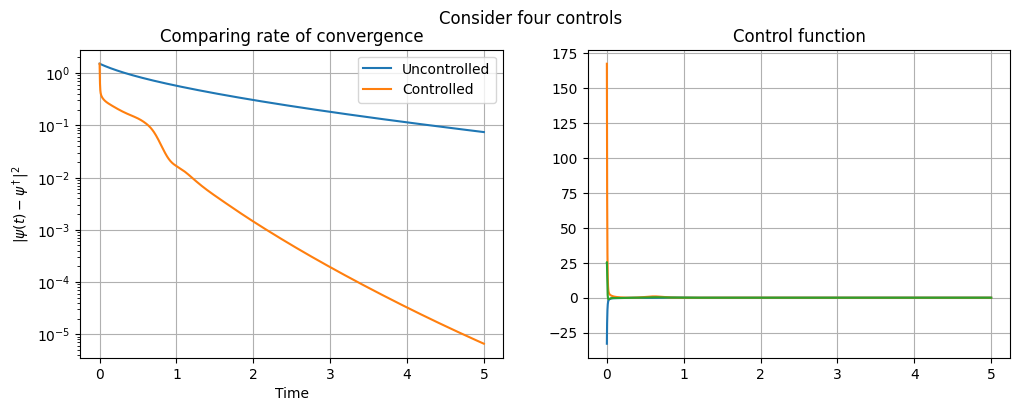

In [12]:
diff_control = np.sum((result_controls[-1]['a_vals'] - solvers[-1].a_dag)**2, axis=1)
diff_nocontrol = np.sum((result['a_vals'] - solvers[-1].a_dag)**2, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')
ax[0].plot(result_controls[-1]['time'], diff_control, label='Controlled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_controls[-1]['time'], result_controls[-1]['u_vals'][:, 0])
ax[1].plot(result_controls[-1]['time'], result_controls[-1]['u_vals'][:, 1])
ax[1].plot(result_controls[-1]['time'], result_controls[-1]['u_vals'][:, 2])
ax[1].grid(True)
ax[1].set_title("Control function")
fig.suptitle("Consider four controls")

plt.show()

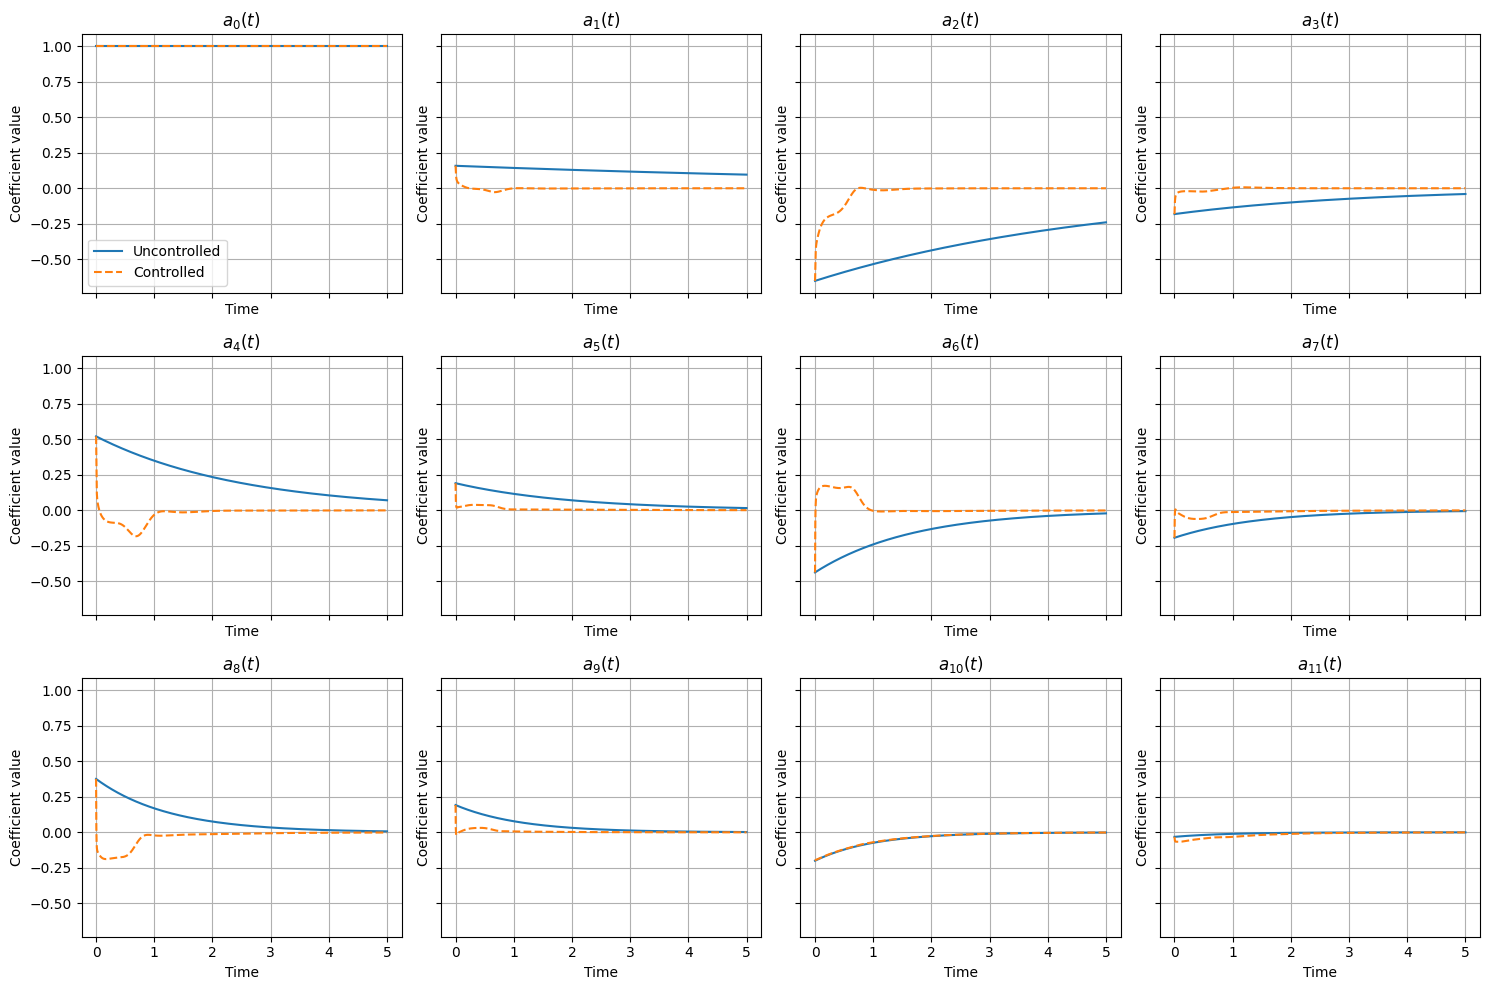

In [13]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_controls[-1]['time'], result_controls[-1]['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

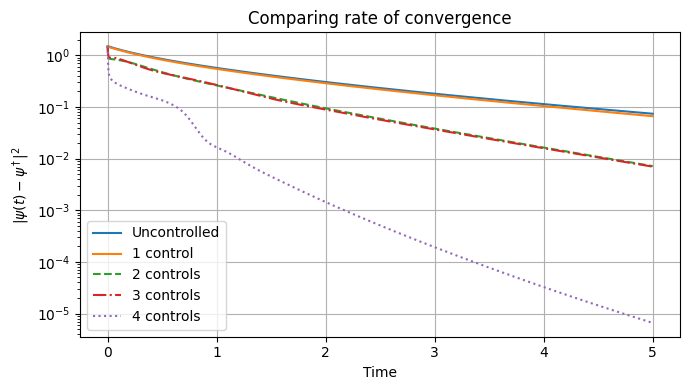

In [15]:
fig, ax = plt.subplots(figsize=(7, 4))

# Line styles to cycle through
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Add more if needed

# Uncontrolled difference
diff_nocontrol = np.sum((result['a_vals'] - solvers[-1].a_dag) ** 2, axis=1)
ax.plot(result['time'], diff_nocontrol, linestyle='-', label='Uncontrolled')

# Controlled differences for each number of controls
for i, (res, solver) in enumerate(zip(result_controls, solvers)):
    diff_control = np.sum((res['a_vals'] - solver.a_dag) ** 2, axis=1)
    style = linestyles[i % len(linestyles)]
    ax.plot(res['time'], diff_control, linestyle=style, label=f'{i+1} control{"s" if i > 0 else ""}')

ax.set_xlabel('Time')
ax.set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax.set_title('Comparing rate of convergence')
ax.set_yscale('log')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

## Understanding the cost functional

Here I will understand $u(t) = A e^{-\lambda t}$ with parameters $A$ and $\lambda$. The idea is to plot the cost functional on $A$ and $\lambda$. 

In [23]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=0,
    nu=1e-3,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

In [24]:
T = 5.0
time_eval = np.linspace(0, T, 1000)

A_values = np.linspace(-100, 100, 31)
lambda_values = np.linspace(0.5, 10, 31)

cost_matrix = np.zeros((len(A_values), len(lambda_values)))

for i, A in enumerate(A_values):
    for j, lam in enumerate(lambda_values):
        u_func = lambda t, A=A, lam=lam: A * np.exp(-lam * t)
        cost = solver.compute_cost_functional([u_func], T, time_eval)
        cost_matrix[i, j] = cost

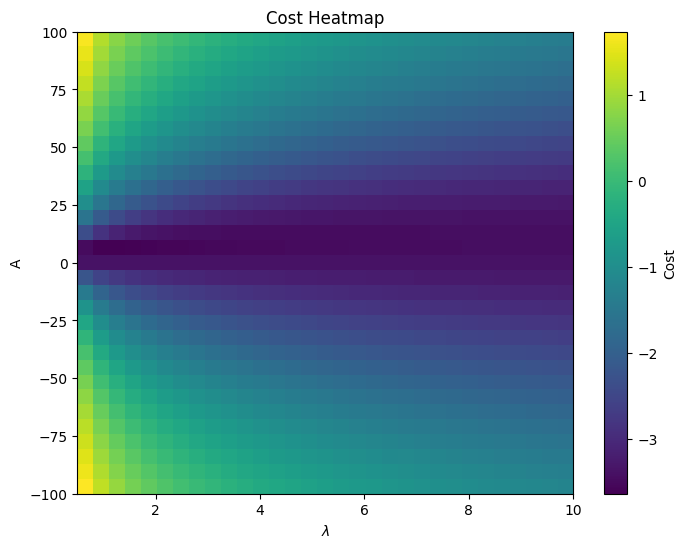

In [25]:
plt.figure(figsize=(8, 6))
plt.imshow(np.log(cost_matrix), origin='lower', extent=[lambda_values[0], lambda_values[-1], A_values[0], A_values[-1]],
           aspect='auto', cmap='viridis')
plt.xlabel(r'$\lambda$')
plt.ylabel('A')
plt.title('Cost Heatmap')
cbar = plt.colorbar()
cbar.set_label('Cost')
plt.show()

## Paper figures

In [2]:
import scienceplots

plt.style.use(['science', 'ieee'])
cmap = 'viridis'

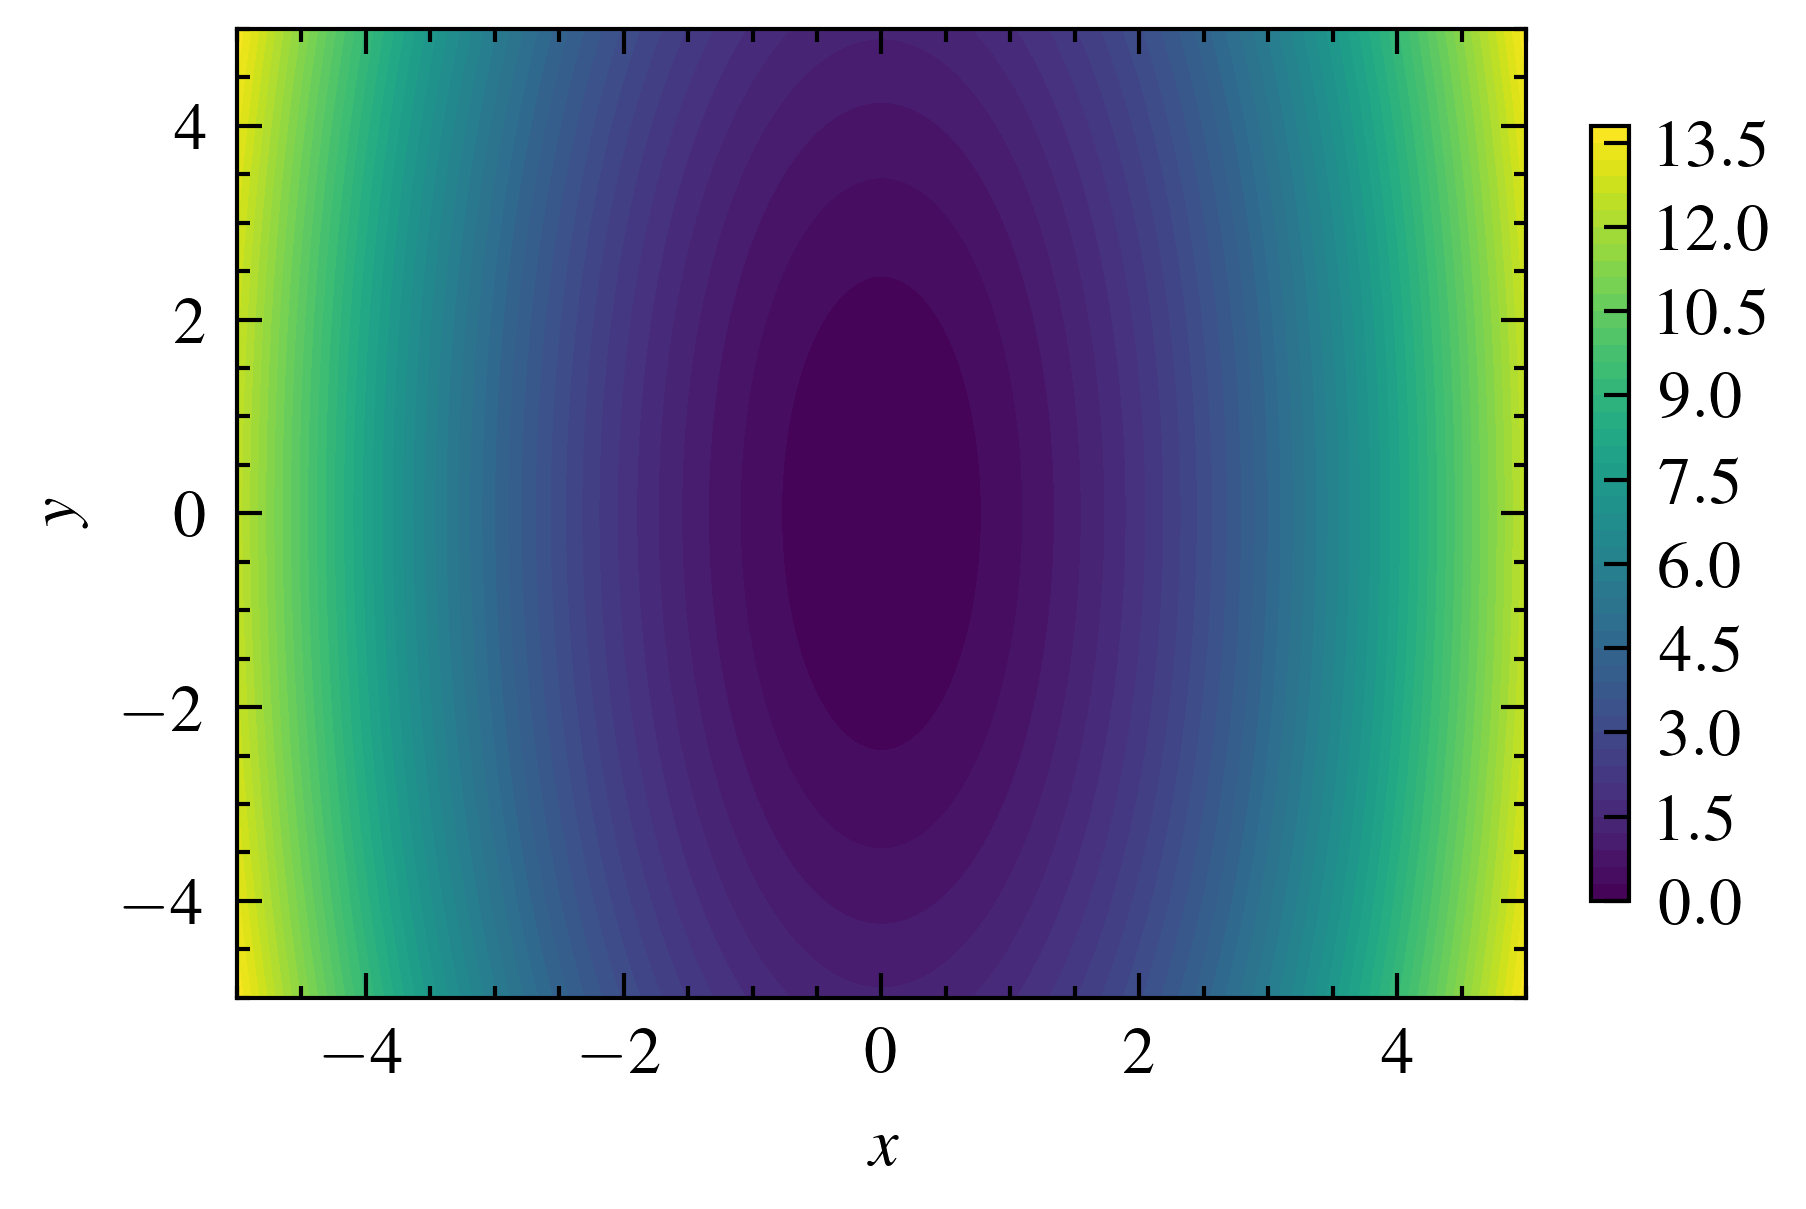

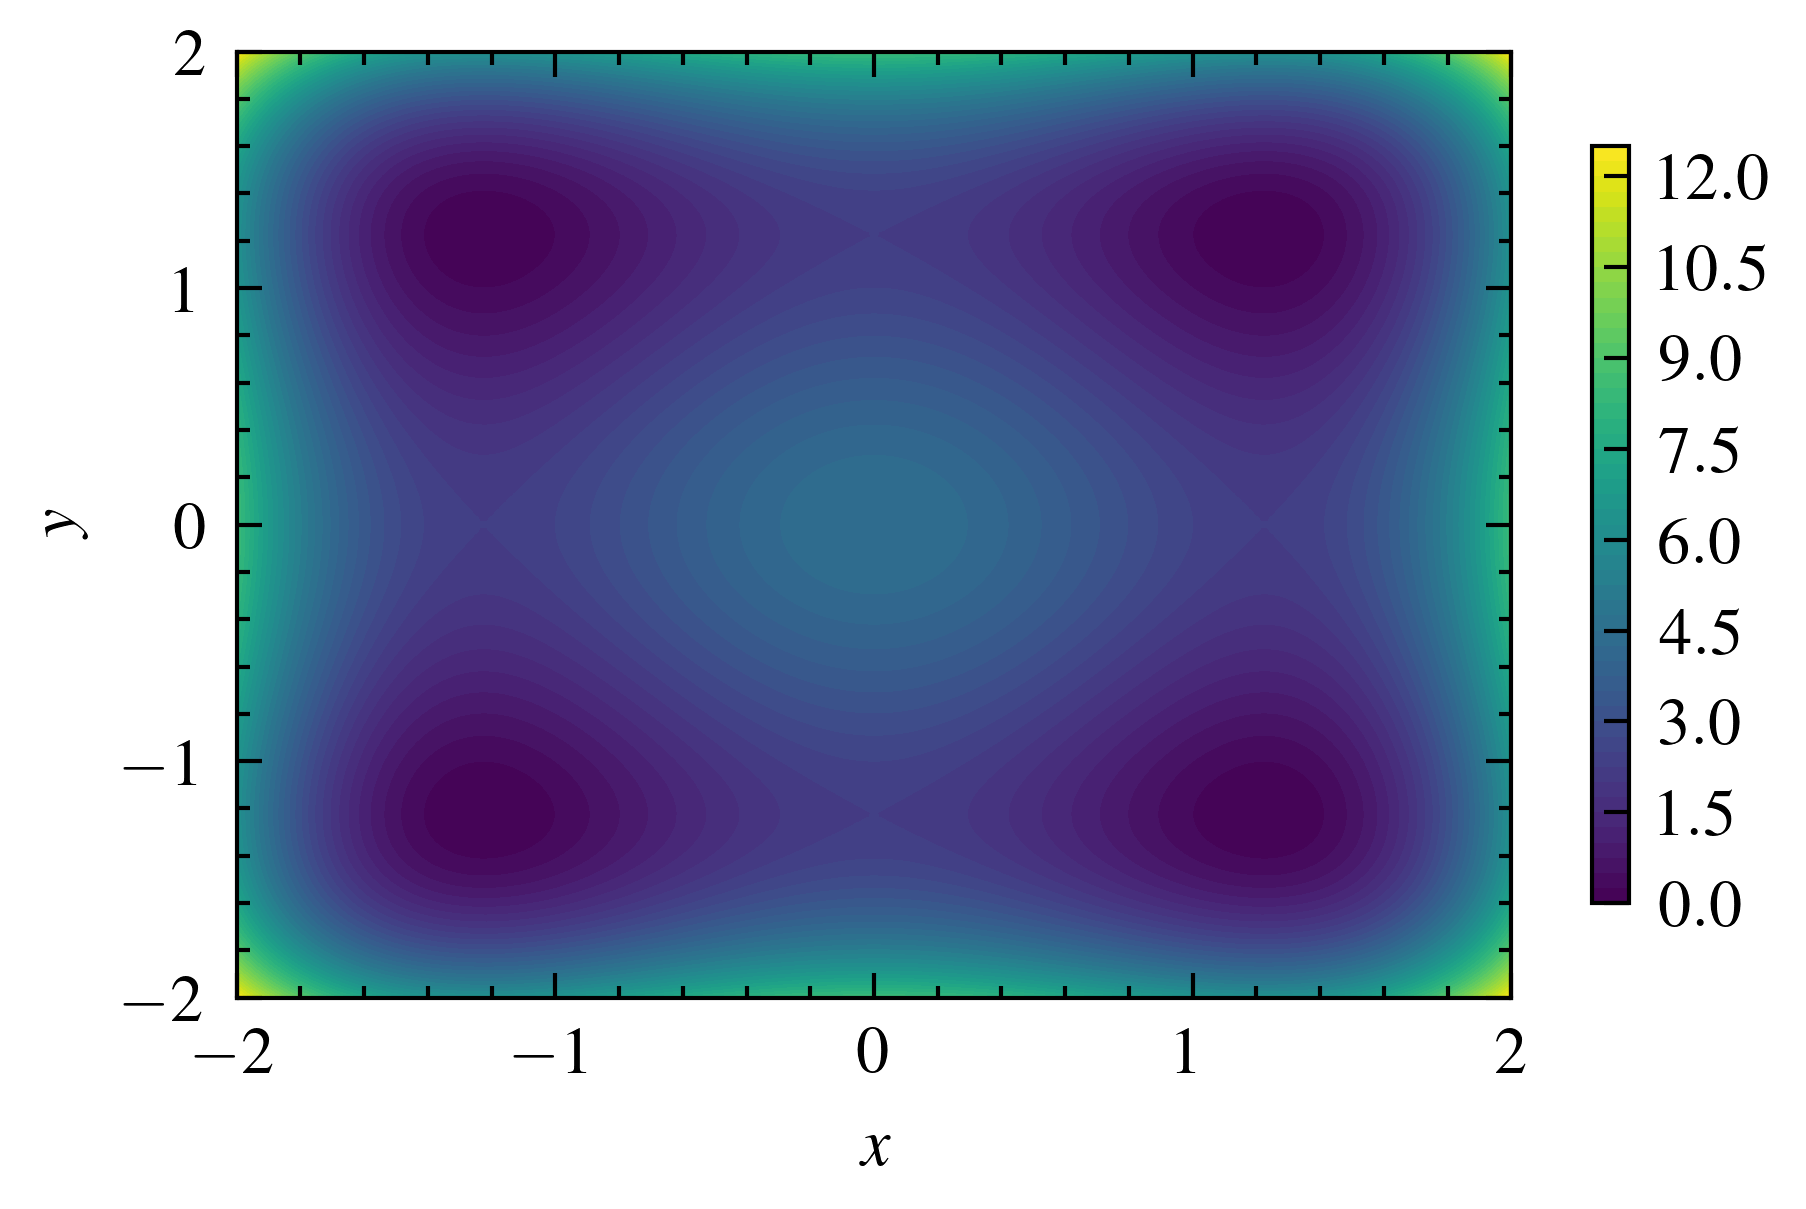

In [3]:
# Create composite figure with two subplots
fig, axes = plt.subplots(1, 1, figsize=(3, 2), constrained_layout=True)

a = 1.0
b = 0.1
xmin, xmax, nx = -5, 5, 200
ymin, ymax, ny = -5, 5, 200
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
V1 = 0.5 * (a * X**2 + b * Y**2)

# Plot quadratic potential
cp1 = axes.contourf(X, Y, V1, levels=50, cmap=cmap)
#axes[0].set_title(r'Quadratic Potential $V_1$')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$y$')
fig.colorbar(cp1, ax=axes, shrink=0.8)

# Save the figure as a PDF
plt.savefig('../images/potential_1.pdf', format='pdf')
plt.show()
plt.close()

c_x = 1.5
c_y = 1.5
xmin, xmax, nx = -2, 2, 200
ymin, ymax, ny = -2, 2, 200
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
V1 = 0.5 * (a * X**2 + b * Y**2)
V2 = (X**2 - c_x)**2 + (Y**2 - c_y)**2

fig, axes = plt.subplots(1, 1, figsize=(3, 2), constrained_layout=True)

# Plot double-well potential
cp2 = axes.contourf(X, Y, V2, levels=50, cmap=cmap)
#axes[1].set_title(r'Double-Well Potential $V_2$')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$y$')
fig.colorbar(cp2, ax=axes, shrink=0.8)

# Save the figure as a PDF
plt.savefig('../images/potential_2.pdf', format='pdf')
plt.show()
plt.close()

In [4]:
# Define parameters for the quadratic potential tests
a_value = 1.0
b_values = [0.5, 0.1, 0.05]
T = 5.0

# Function to define the quadratic potential
def potential(X, Y, a, b):
    return 0.5 * (a * X**2 + b * Y**2)

def run_solver(b_value, control=True):
    approximator = AnalyticSchrodingerApproximator(
        L=(3.0, 15.0),
        N=(500, 500),
        sigma=1.0,
        a=a_value,
        b=b_value,
    )
    eigeninfo = approximator.solve_eigen(num_eigen=50, derivative=True)
    
    # Define initial density rho_0 using a shifted Gaussian-like function.
    def integrand(r):
        return r * np.exp(-1 / (1 - r**2 / 4))
    integral_value, _ = quad(integrand, 0, 2)
    C = 1 / (2 * np.pi * integral_value)
    
    def rho_0(X, Y):
        r2 = (X + 0.2)**2 + (Y - 0.5)**2  # Shift the center to (-0.5, 0.5)
        out = np.zeros_like(r2)
        mask = r2 < 4  # Support within r < 2
        out[mask] = C * np.exp(-1 / (1 - r2[mask] / 4))
        return out
    
    nabla_V = lambda X, Y: (a_value * X, b_value * Y)
    
    solver = SchrodingerControlSolver(
        approximator=approximator,
        num_eigen=50,
        potential=lambda X, Y: potential(X, Y, a_value, b_value),
        rho_0=rho_0,
        rho_dag=None,
        kappa=5.0,
        nu=1e-4,
        nabla_alpha_list=None,
        nabla_V=nabla_V,
        correct_lambda0=True,
        eigeninfo=eigeninfo,
        compute_alpha=4
    )
    
    if control:
        result = solver.solve(
            T=T, 
            max_iter=500,
            tol=1e-3,
            time_eval=T * np.linspace(0, 1, 1001)**2,
            verbose=True,
            learning_rate_kwargs={'method': 'bb', 'gamma': 0.01},
            inicialization=True
        )
        return result, solver.v_initial, solver
    else:
        result = solver.solve(
            T=T, 
            max_iter=1, 
            tol=1e-3, 
            time_eval=T * np.linspace(0, 1, 1001)**2, 
            verbose=True, 
            control_funcs=[lambda t: np.zeros_like(t)], 
            optimise=False
        )
        return result

results_control = {}
results_uncontrol = {}
for b_val in b_values:
    results_control[b_val] = run_solver(b_val, control=True)
    results_uncontrol[b_val] = run_solver(b_val, control=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 1.157e+00, gamma = 0.01
Iteration 2: ||grad|| = 7.535e-01, gamma = 0.047930486703092794
Iteration 3: ||grad|| = 4.740e-01, gamma = 0.05809492681242633
Iteration 4: ||grad|| = 6.726e-01, gamma = 0.03730980070008677
Iteration 5: ||grad|| = 3.427e-01, gamma = 0.03340866813978698
Iteration 6: ||grad|| = 1.938e-01, gamma = 0.02999839987907937
Iteration 7: ||grad|| = 1.628e-01, gamma = 0.1137746665549135
Iteration 8: ||grad|| = 1.575e-01, gamma = 0.39208949363603585
Iteration 9: ||grad|| = 8.773e-01, gamma = 0.1362801448927114
Iteration 10: ||grad|| = 4.166e+00, gamma = 0.02285416546444373
Iteration 11: ||grad|| = 2.383e-01, gamma = 0.022902641481520568
Iteration 12: ||grad|| = 1.242e-01, gamma = 0.03579007484704958
Iteration 13: ||grad|| = 9.580e-02, gamma = 0.08363083763323398
Iteration 14: ||grad|| = 9.395e-02, gamma = 1.0682921927442182
Iteration 15: ||grad|| = 3.747e-01, gamma = 0.6514377283154288
Iteration 16: ||grad|| = 8.265e

In [5]:
errors_control = {}
errors_subcontrol = {}
errors_uncontrol = {}
for b_val in b_values:
    a_ctrl = results_control[b_val][0]['a_vals']
    a_subctrl = results_control[b_val][1]
    a_unctrl = results_uncontrol[b_val]['a_vals']
    a_dag = np.zeros_like(results_control[b_val][0]['a_vals'][0])
    a_dag[0] = 1.0
    errors_control[b_val] = np.sum((a_ctrl - a_dag)**2, axis=1)
    errors_subcontrol[b_val] = np.sum((a_subctrl - a_dag)**2, axis=1)
    errors_uncontrol[b_val] = np.sum((a_unctrl - a_dag)**2, axis=1)

Python(2670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


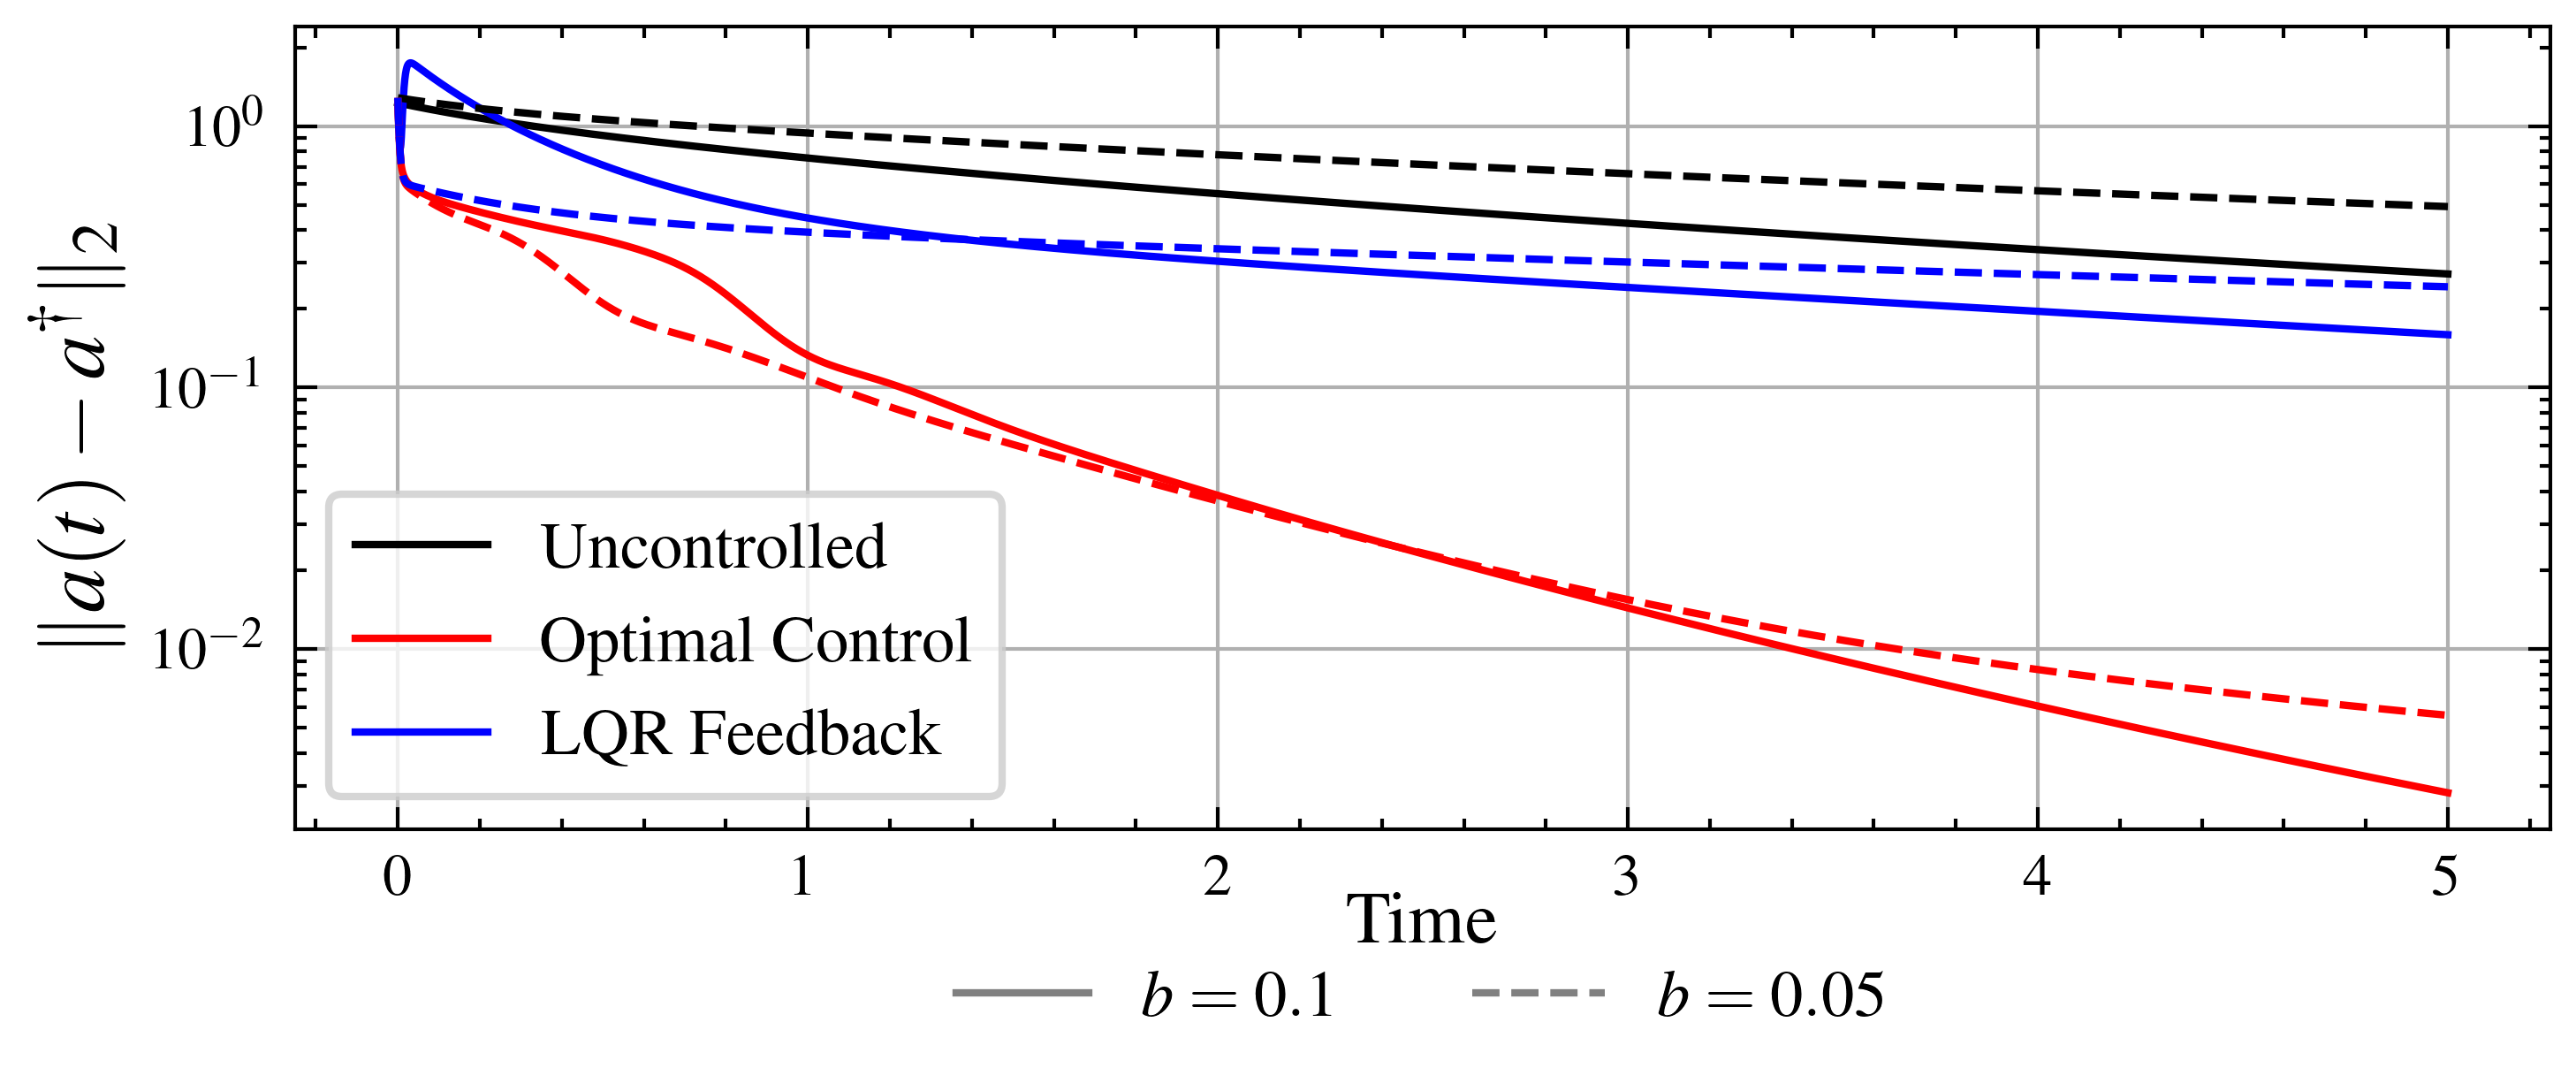

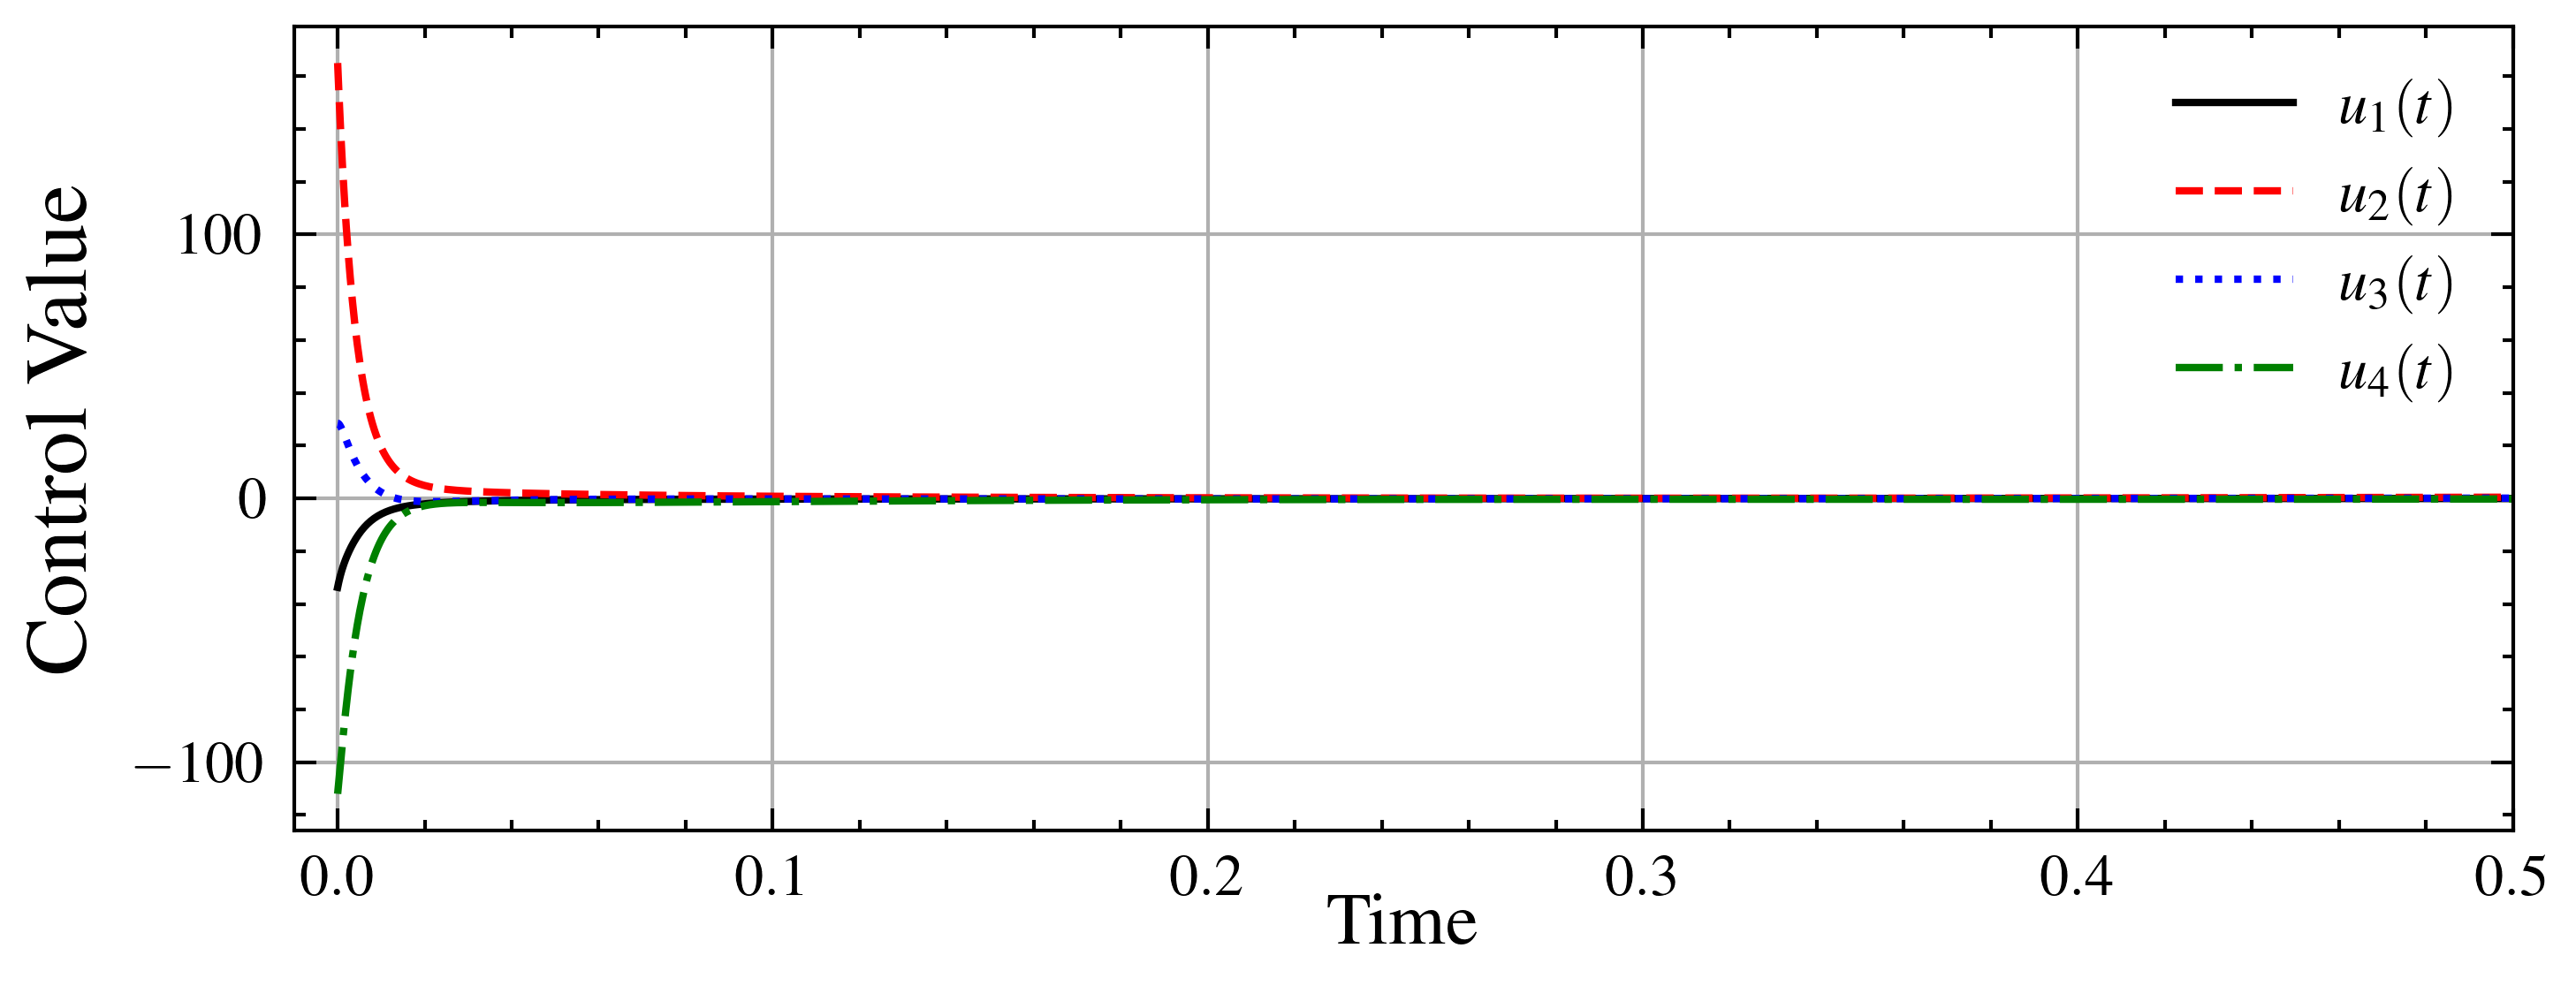

In [6]:
colors = ['C0', 'C1', 'C2']  # One color per b value
line_styles = {
    0: ":",
    1: '-',
    2: '--',
}

fig1, ax1 = plt.subplots(figsize=(5, 2.2))

for enum, b_val in enumerate(b_values):
    if enum == 0: continue
    ax1.plot(results_uncontrol[b_val]['time'], np.sqrt(errors_uncontrol[b_val]),
             linestyle=line_styles[enum], color=colors[0])
    ax1.plot(results_control[b_val][0]['time'], np.sqrt(errors_control[b_val]),
             linestyle=line_styles[enum], color=colors[1])
    ax1.plot(results_control[b_val][0]['time'], np.sqrt(errors_subcontrol[b_val]),
             linestyle=line_styles[enum], color=colors[2])

# Labels and scale
ax1.set_xlabel('Time', fontsize=10, labelpad=-2)
ax1.set_ylabel(r'$\|a(t) - a^\dagger\|_2$', fontsize=12)
ax1.set_yscale('log')
ax1.grid(True)

# Create control-type legend (line styles)
control_legend = [
    Line2D([0], [0], linestyle='-', color=colors[0], label='Uncontrolled'),
    Line2D([0], [0], linestyle='-',  color=colors[1], label='Optimal Control'),
    Line2D([0], [0], linestyle='-',  color=colors[2], label='LQR Feedback')
]
legend1 = ax1.legend(handles=control_legend, loc='lower left', fontsize=9, frameon=True)
ax1.add_artist(legend1)

# Create b-value legend (colors), aligned beneath the plot
b_legend = [
    Line2D([0], [0], linestyle='-', color='grey', label=r'$b=0.1$'),
    Line2D([0], [0], linestyle='--', color='grey', label=r'$b=0.05$')
]
ax1.legend(handles=b_legend, loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=2, fontsize=9, frameon=False)

fig1.tight_layout()
fig1.savefig('../images/error_convergence_v1.pdf', format='pdf')
plt.show()

# SECOND PLOT: Control values for b = 0.1
result_b01 = results_control[0.1][0]
time_ctrl = result_b01['time']
u_vals = result_b01['u_vals']  # assume shape: (num_time_points, num_controls)

fig2, ax2 = plt.subplots(figsize=(5, 2))
for j in range(u_vals.shape[1]):
    ax2.plot(time_ctrl, u_vals[:, j], label=f'$u_{{{j+1}}}(t)$')

ax2.set_xlim((-0.01, 0.5))
ax2.set_xlabel('Time', fontsize=10, labelpad=-2)
ax2.set_ylabel('Control Value', fontsize=12)
ax2.legend(fontsize=8)
ax2.grid(True)
fig2.tight_layout()
fig2.savefig('../images/control_profiles_v1.pdf', format='pdf')
plt.show()

plt.close("all")

Misalignment

In [18]:
def bump_pdf(X, Y, mu=(0.0,0.0), sigma=1.0):
    Z = 1/(2*np.pi*sigma**2)
    return Z * np.exp(-(((X-mu[0])**2 + (Y-mu[1])**2)/(2*sigma**2)))

eps_values  = [1.0, 5.0, 10.0]
b_values    = [0.1]
misaligned_results = {}

for b in b_values:
    result, _, solver = results_control[b]
    X, Y = np.meshgrid(solver.x, solver.y, indexing='ij')
    dx, dy = solver.dx, solver.dy
    
    misaligned_results[b] = {0.0: result['a_vals']}
    
    for eps in eps_values:
        # build and normalize the bump
        bump = bump_pdf(X, Y)
        db_dx = -(X - 0.0) / 1.0**2 * bump
        db_dy = -(Y - 0.0) / 1.0**2 * bump
    
        new_nabla = []
        for (grad_alpha_x, grad_alpha_y) in solver.nabla_alpha_list:
            new_nabla.append((grad_alpha_x + eps*db_dx,
                              grad_alpha_y + eps*db_dy))

        solver_mis = SchrodingerControlSolver(
                        approximator=solver.approximator,
                        num_eigen=50,
                        potential=solver.potential,
                        rho_0=solver.rho_0,
                        rho_dag=None,
                        kappa=5.0,
                        nu=1e-4,
                        nabla_alpha_list=new_nabla,
                        nabla_V=lambda X, Y: (X, b * Y),
                        correct_lambda0=True,
                        eigeninfo=(solver.eigvals, solver.eigfuncs, solver.nabla_eigfuncs),
                        compute_alpha=None
                    )
        
        misresult = solver_mis.solve(
            T=T,
            max_iter=500,
            tol=1e-3,
            time_eval=T * np.linspace(0, 1, 1001)**2,
            verbose=True,
            learning_rate_kwargs={'method': 'bb', 'gamma': 0.01},
            inicialization=True
        )
        misaligned_results[b][eps] = misresult['a_vals']

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 1.567e+01, gamma = 0.01
Iteration 2: ||grad|| = 6.960e+00, gamma = 0.01098433837935703
Iteration 3: ||grad|| = 5.884e+00, gamma = 0.08463187650900175
Iteration 4: ||grad|| = 5.882e+00, gamma = 0.06834877687199219
Iteration 5: ||grad|| = 4.155e+00, gamma = 0.03523413824269565
Iteration 6: ||grad|| = 1.200e+00, gamma = 0.060494065060212626
Iteration 7: ||grad|| = 7.791e-01, gamma = 0.07917660431122238
Iteration 8: ||grad|| = 7.150e-01, gamma = 0.05913238444954775
Iteration 9: ||grad|| = 5.103e-01, gamma = 0.08548232602974495
Iteration 10: ||grad|| = 5.493e-01, gamma = 0.05898152005730091
Iteration 11: ||grad|| = 3.982e-01, gamma = 0.07431221889827117
Iteration 12: ||grad|| = 4.422e-01, gamma = 0.038162778488495926
Iteration 13: ||grad|| = 1.401e-01, gamma = 0.06556516783630832
Iteration 14: ||grad|| = 1.241e-01, gamma = 0.35036859070336773
Iteration 15: ||grad|| = 8.479e-01, gamma = 0.18753439042498318
Iteration 16: ||grad|| = 3.

In [20]:
e0 = np.linalg.norm(misaligned_results[0.1][0.0] - solver.a_dag, axis=1)[-1]
e1 = np.linalg.norm(misaligned_results[0.1][1.0] - solver.a_dag, axis=1)[-1]
e10 = np.linalg.norm(misaligned_results[0.1][5.0] - solver.a_dag, axis=1)[-1]
e100 = np.linalg.norm(misaligned_results[0.1][10.0] - solver.a_dag, axis=1)[-1]
print((e1-e0)/e0)
print((e10-e0)/e0)
print((e100-e0)/e0)

0.09522862911641491
0.1737004188453181
9.502317915916297


In [7]:
potential_expr_str = "4*x^6-12*x^4+3*x^2+4*y^6-12*y^4+3*y^2+6"

approximator = WolframNDEigensystemApproximator(
    potential_expr=potential_expr_str,
    L=(3.0, 3.0),
    N=(500, 500),
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)
eigeninfo = approximator.solve_eigen(num_eigen=50, derivative=True)

def potential(X, Y):
    return (X**2 - 1.5)**2 + (Y**2 - 1.5)**2

def integrand(r):
    return r * np.exp(-1 / (1 - r**2 / 4))
integral_value, _ = quad(integrand, 0, 2)
C = 1 / (2 * np.pi * integral_value)

def rho_0(X, Y):
    r2 = (X + 0.2)**2 + (Y - 0.5)**2  # Shift the center to (0.5, 0.5)
    out = np.zeros_like(r2)
    mask = r2 < 4  # Support within r < 2
    out[mask] = C * np.exp(-1 / (1 - r2[mask] / 4))
    return out

nabla_V = lambda X, Y: (4*(X**2 - 1.5)*X, 4*(Y**2 - 1.5)*Y)

solver2d = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=5.0,
    nu=1e-4,
    nabla_alpha_list=None,
    nabla_V=nabla_V,
    correct_lambda0=True,
    eigeninfo=eigeninfo,
    compute_alpha=2
)

Python(2674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [8]:
T = 5.0
result_control = solver2d.solve(
    T=T, 
    max_iter=500, 
    tol=1e-4, 
    time_eval=T*np.linspace(0, 1, 1001)**2, 
    verbose=True, 
    learning_rate_kwargs={'method': 'bb', 'gamma': 1}, 
    inicialization=True
)
result_uncontrol = solver2d.solve(
    T=T, 
    max_iter=1, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    control_funcs=[lambda t: np.zeros_like(t)], 
    optimise=False
)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 2.887e+00, gamma = 1
Iteration 2: ||grad|| = 3.074e+00, gamma = 0.6242256600528862
Iteration 3: ||grad|| = 6.879e-01, gamma = 0.46847068124540103
Iteration 4: ||grad|| = 4.491e-02, gamma = 0.5755122973529717
Iteration 5: ||grad|| = 7.943e-02, gamma = 1.5118896791867098
Iteration 6: ||grad|| = 2.093e-02, gamma = 3.950036605579001
Iteration 7: ||grad|| = 8.962e-02, gamma = 2.760905234693846
Iteration 8: ||grad|| = 4.623e-01, gamma = 0.5243417712438178
Iteration 9: ||grad|| = 3.384e-02, gamma = 0.4873741641096251
Iteration 10: ||grad|| = 3.960e-03, gamma = 0.7739321117423011
Iteration 11: ||grad|| = 2.686e-03, gamma = 18.39128389883495
Iteration 12: ||grad|| = 2.851e-02, gamma = 27.673500698820575
Iteration 13: ||grad|| = 9.756e-01, gamma = 0.4723737302711915
Iteration 14: ||grad|| = 2.284e-01, gamma = 0.44124265564400794
Iteration 15: ||grad|| = 1.434e-01, gamma = 1.105447838999978
Iteration 16: ||grad|| = 4.414e-02, gamma = 2.22

Python(3003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


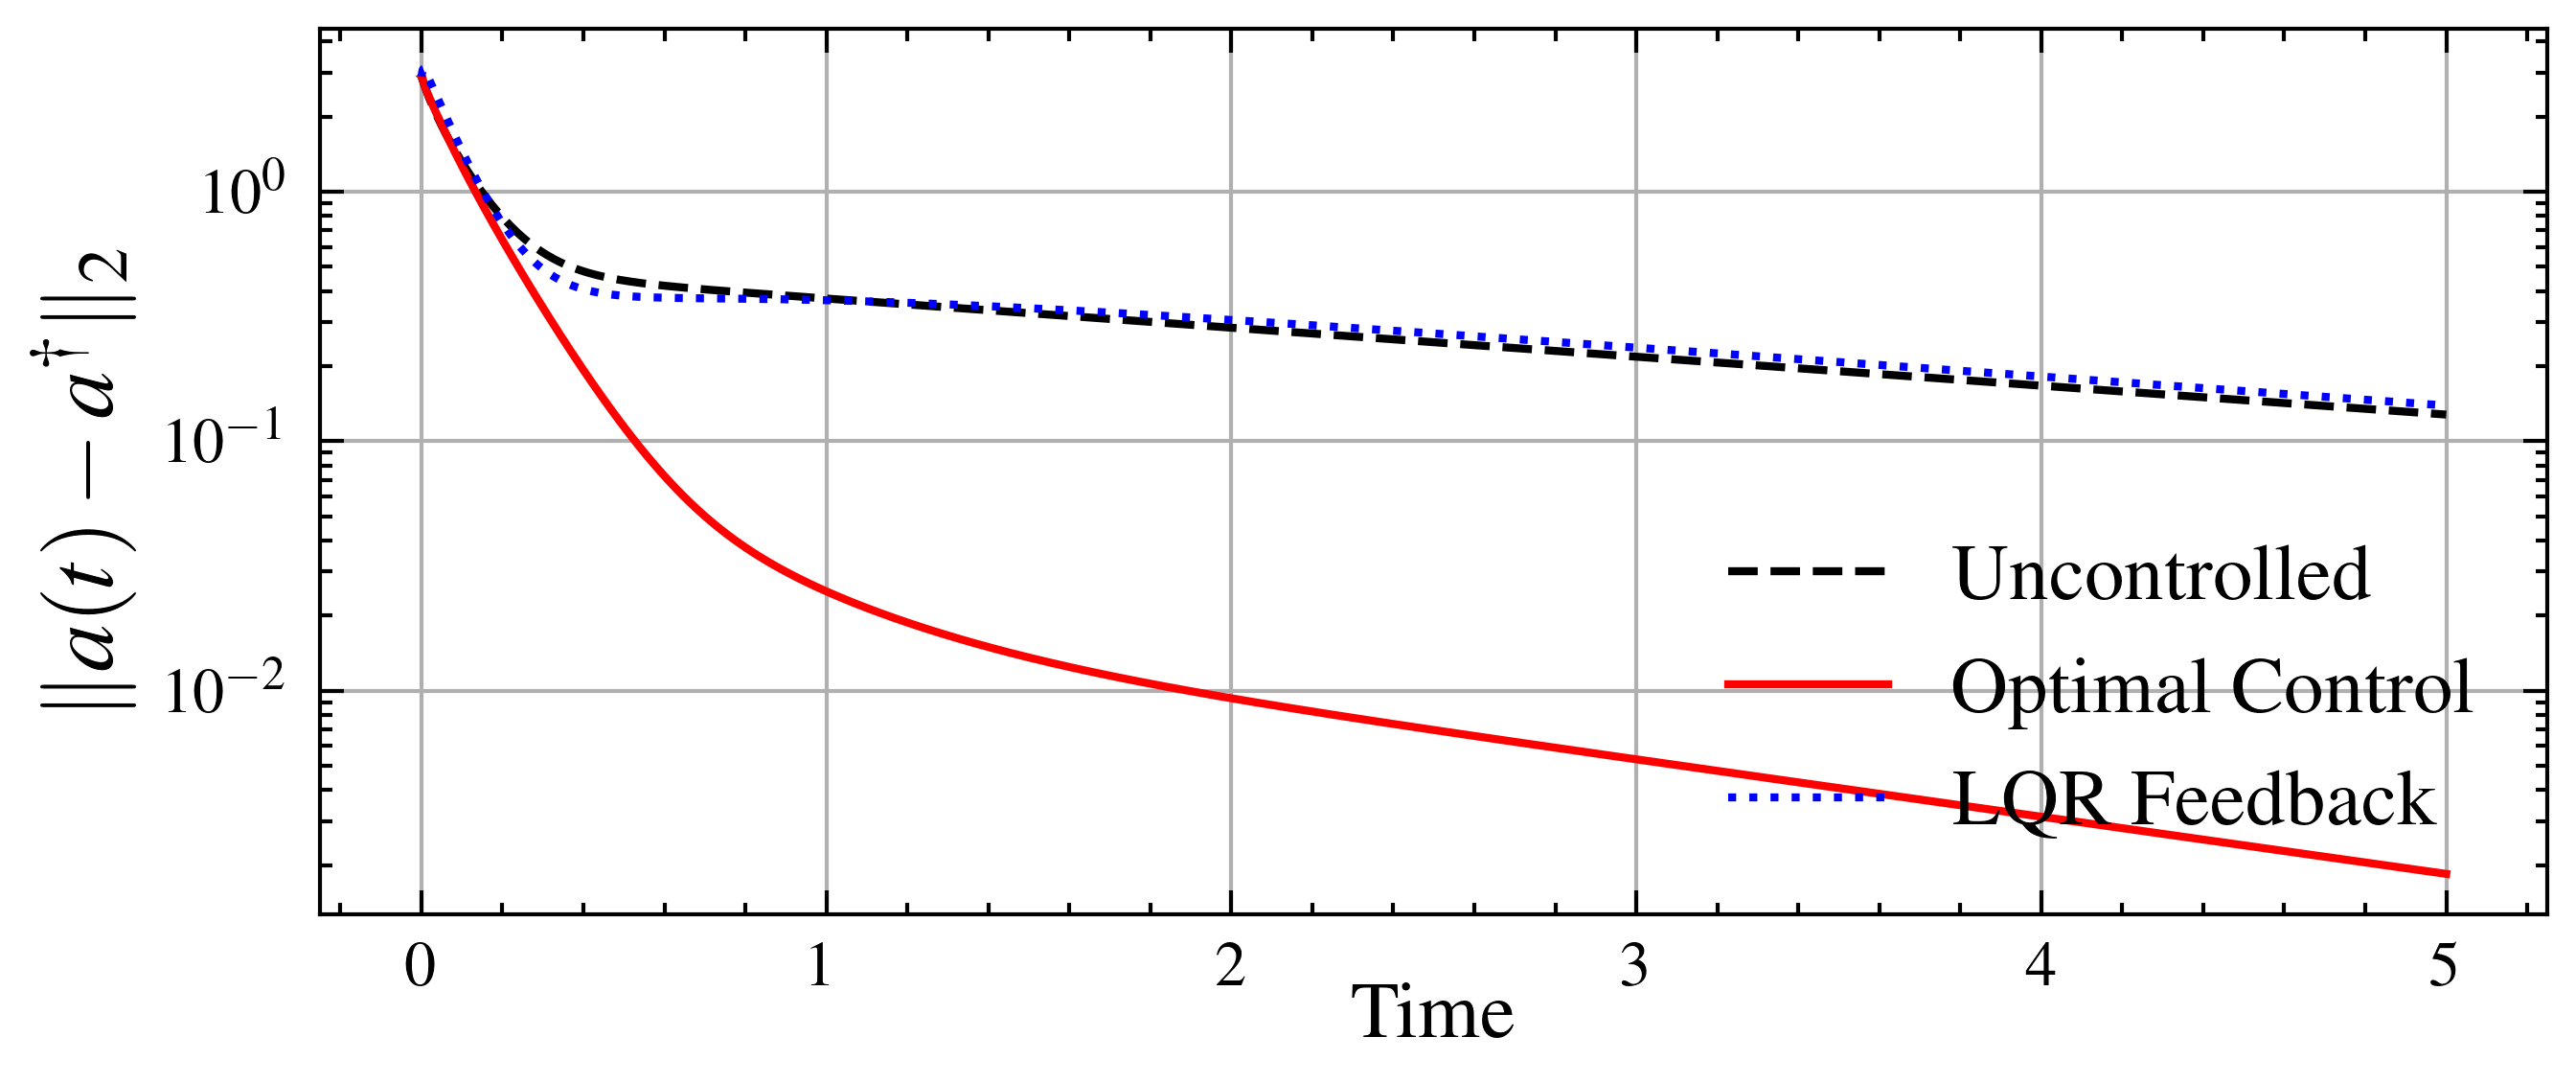

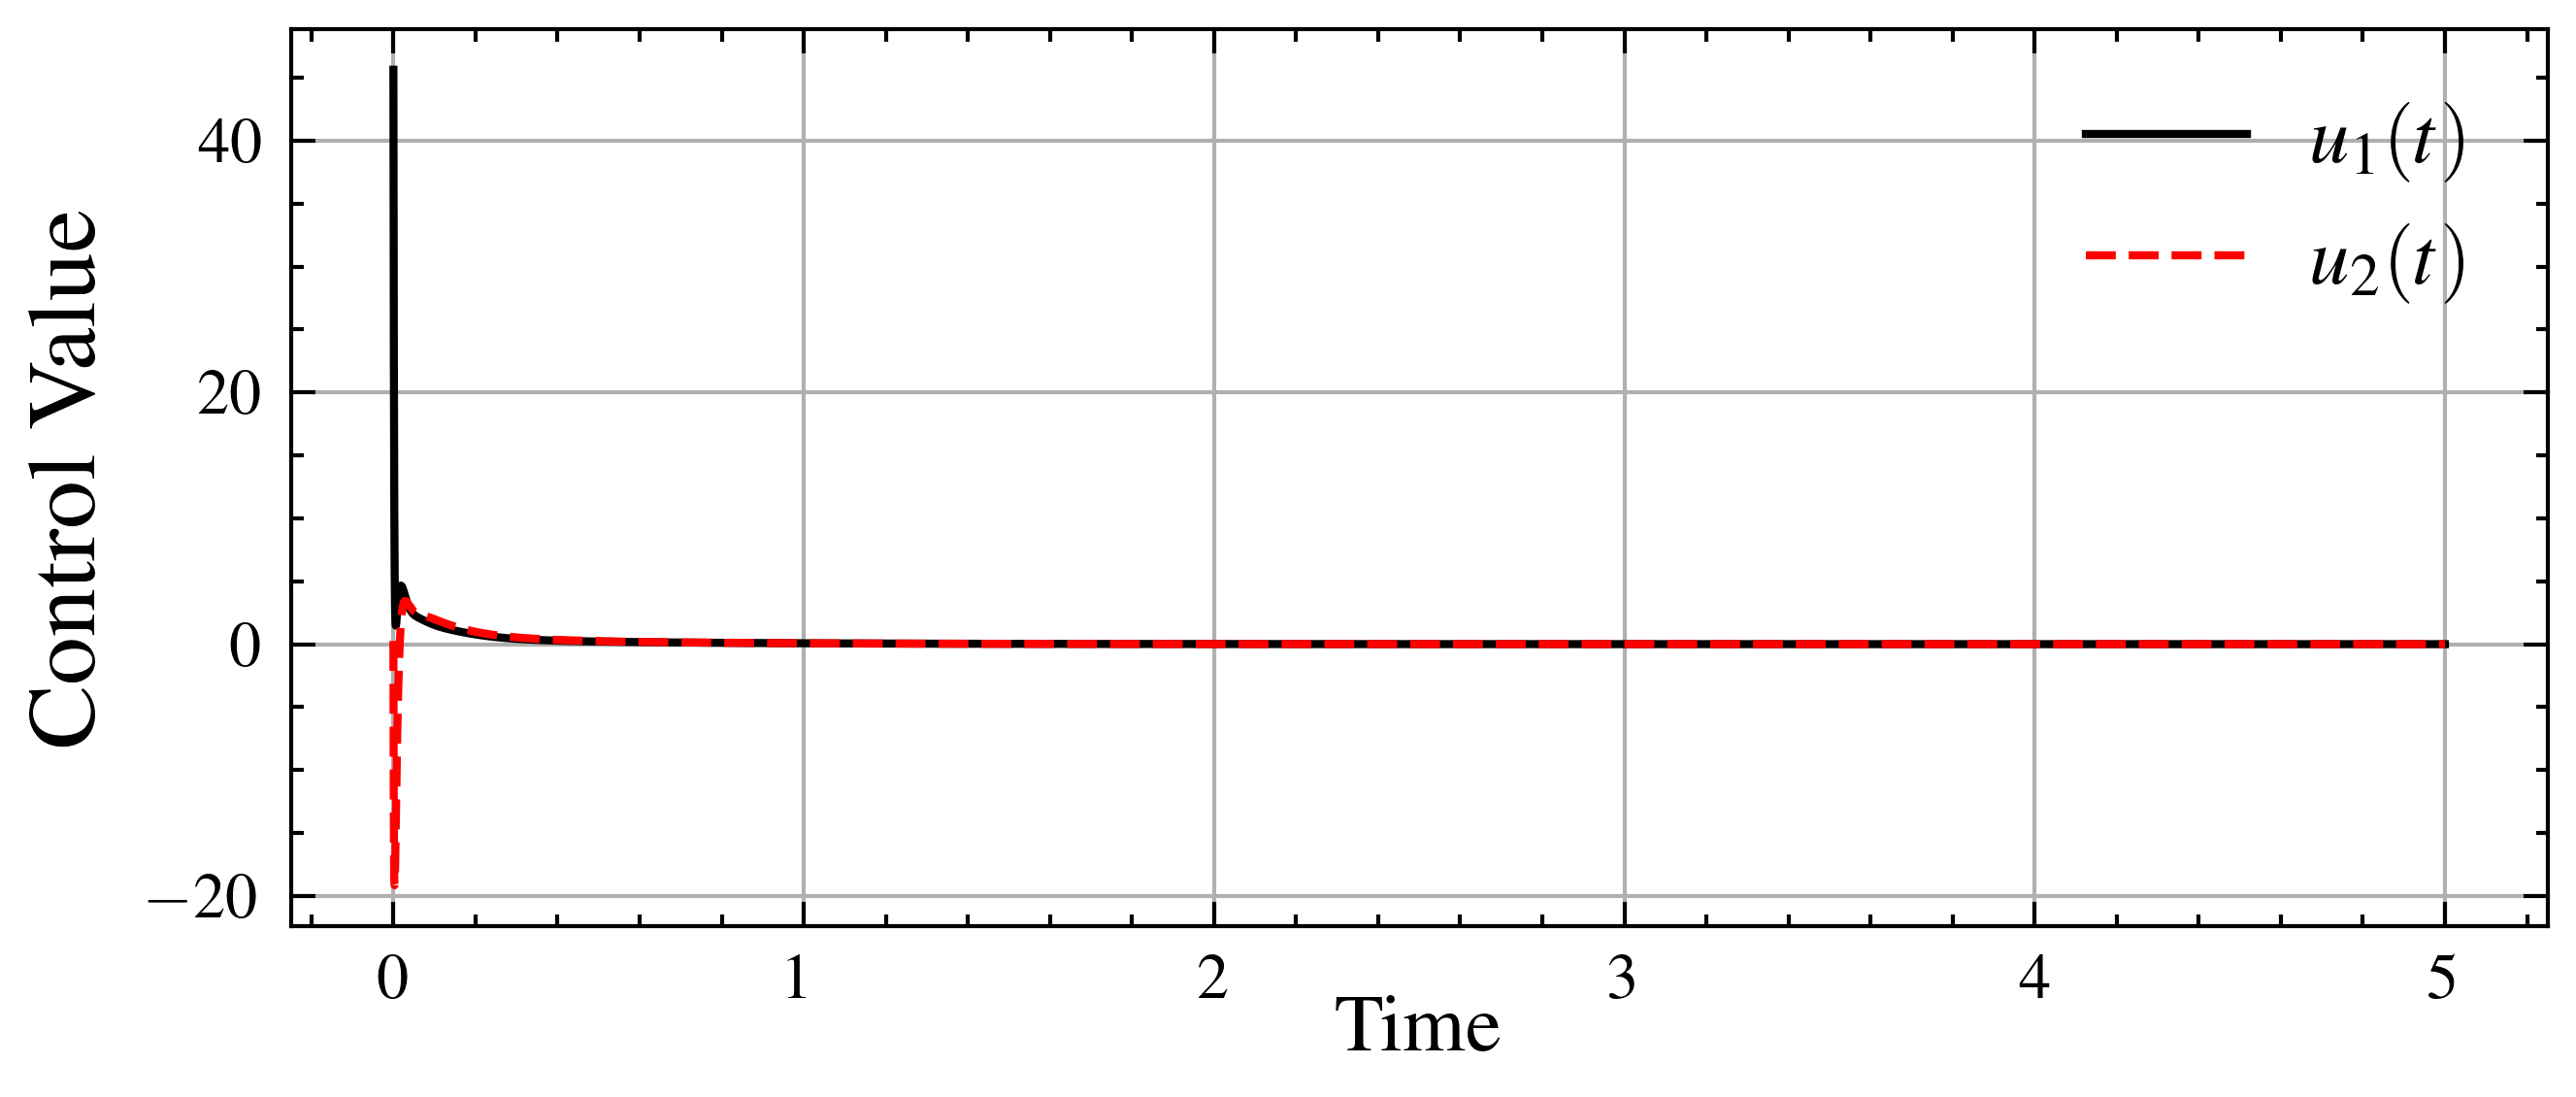

In [9]:
diff_control = np.sum((result_control['a_vals'] - solver2d.a_dag)**2, axis=1)
diff_subcontrol = np.sum((solver2d.v_initial - solver2d.a_dag)**2, axis=1)
diff_uncontrol = np.sum((result_uncontrol['a_vals'] - solver2d.a_dag)**2, axis=1)

fig1, ax1 = plt.subplots(figsize=(5, 2))
ax1.plot(result_uncontrol['time'], np.sqrt(diff_uncontrol), linestyle='--', label='Uncontrolled', color='C0')
ax1.plot(result_control['time'], np.sqrt(diff_control), linestyle='-', label='Optimal Control', color='C1')
ax1.plot(result_control['time'], np.sqrt(diff_subcontrol), linestyle=':', label='LQR Feedback', color='C2')
# (Repeat similar plots for b=0.5 and b=0.05 if available.)
ax1.set_xlabel('Time', fontsize=10, labelpad=-2)
ax1.set_ylabel(r'$\|a(t)-a^\dagger\|_2$', fontsize=12)
#ax1.set_title('Error Convergence')
ax1.legend(fontsize=10)
ax1.grid(True)
ax1.set_yscale('log')
fig1.savefig('../images/error_convergence_v2.pdf', format='pdf')
plt.show()

fig2, ax2 = plt.subplots(figsize=(5, 2))
for j in range(result_control['u_vals'].shape[1]):
    ax2.plot(result_control['time'], result_control['u_vals'][:, j], label=f'$u_{j+1}(t)$')
ax2.set_xlabel('Time', fontsize=10, labelpad=-2)
ax2.set_ylabel('Control Value', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True)
fig2.savefig('../images/control_profiles_v2.pdf', format='pdf')
plt.show()
plt.close('all')

In [71]:
times = result_control['time']
Delta_controlled = np.einsum('tm,mij->tij', result_control['u_vals'], solver2d.Delta)
D = np.tile(np.diag(solver2d.eigvals), (len(times), 1, 1))
H_modified = D - Delta_controlled 

eigenvalues_all = np.linalg.eigvals(H_modified)
real_eigenvalues_parts = np.real(eigenvalues_all)
sorting_eigenvalues = np.take_along_axis(real_eigenvalues_parts, np.argsort(np.abs(real_eigenvalues_parts), axis=1), axis=1)
spectral_gap = sorting_eigenvalues[:, 1] - sorting_eigenvalues[:, 0] 
spectral_abscissa = np.max(real_eigenvalues_parts, axis=1)

Python(4446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4448) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4449) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4450) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4451) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


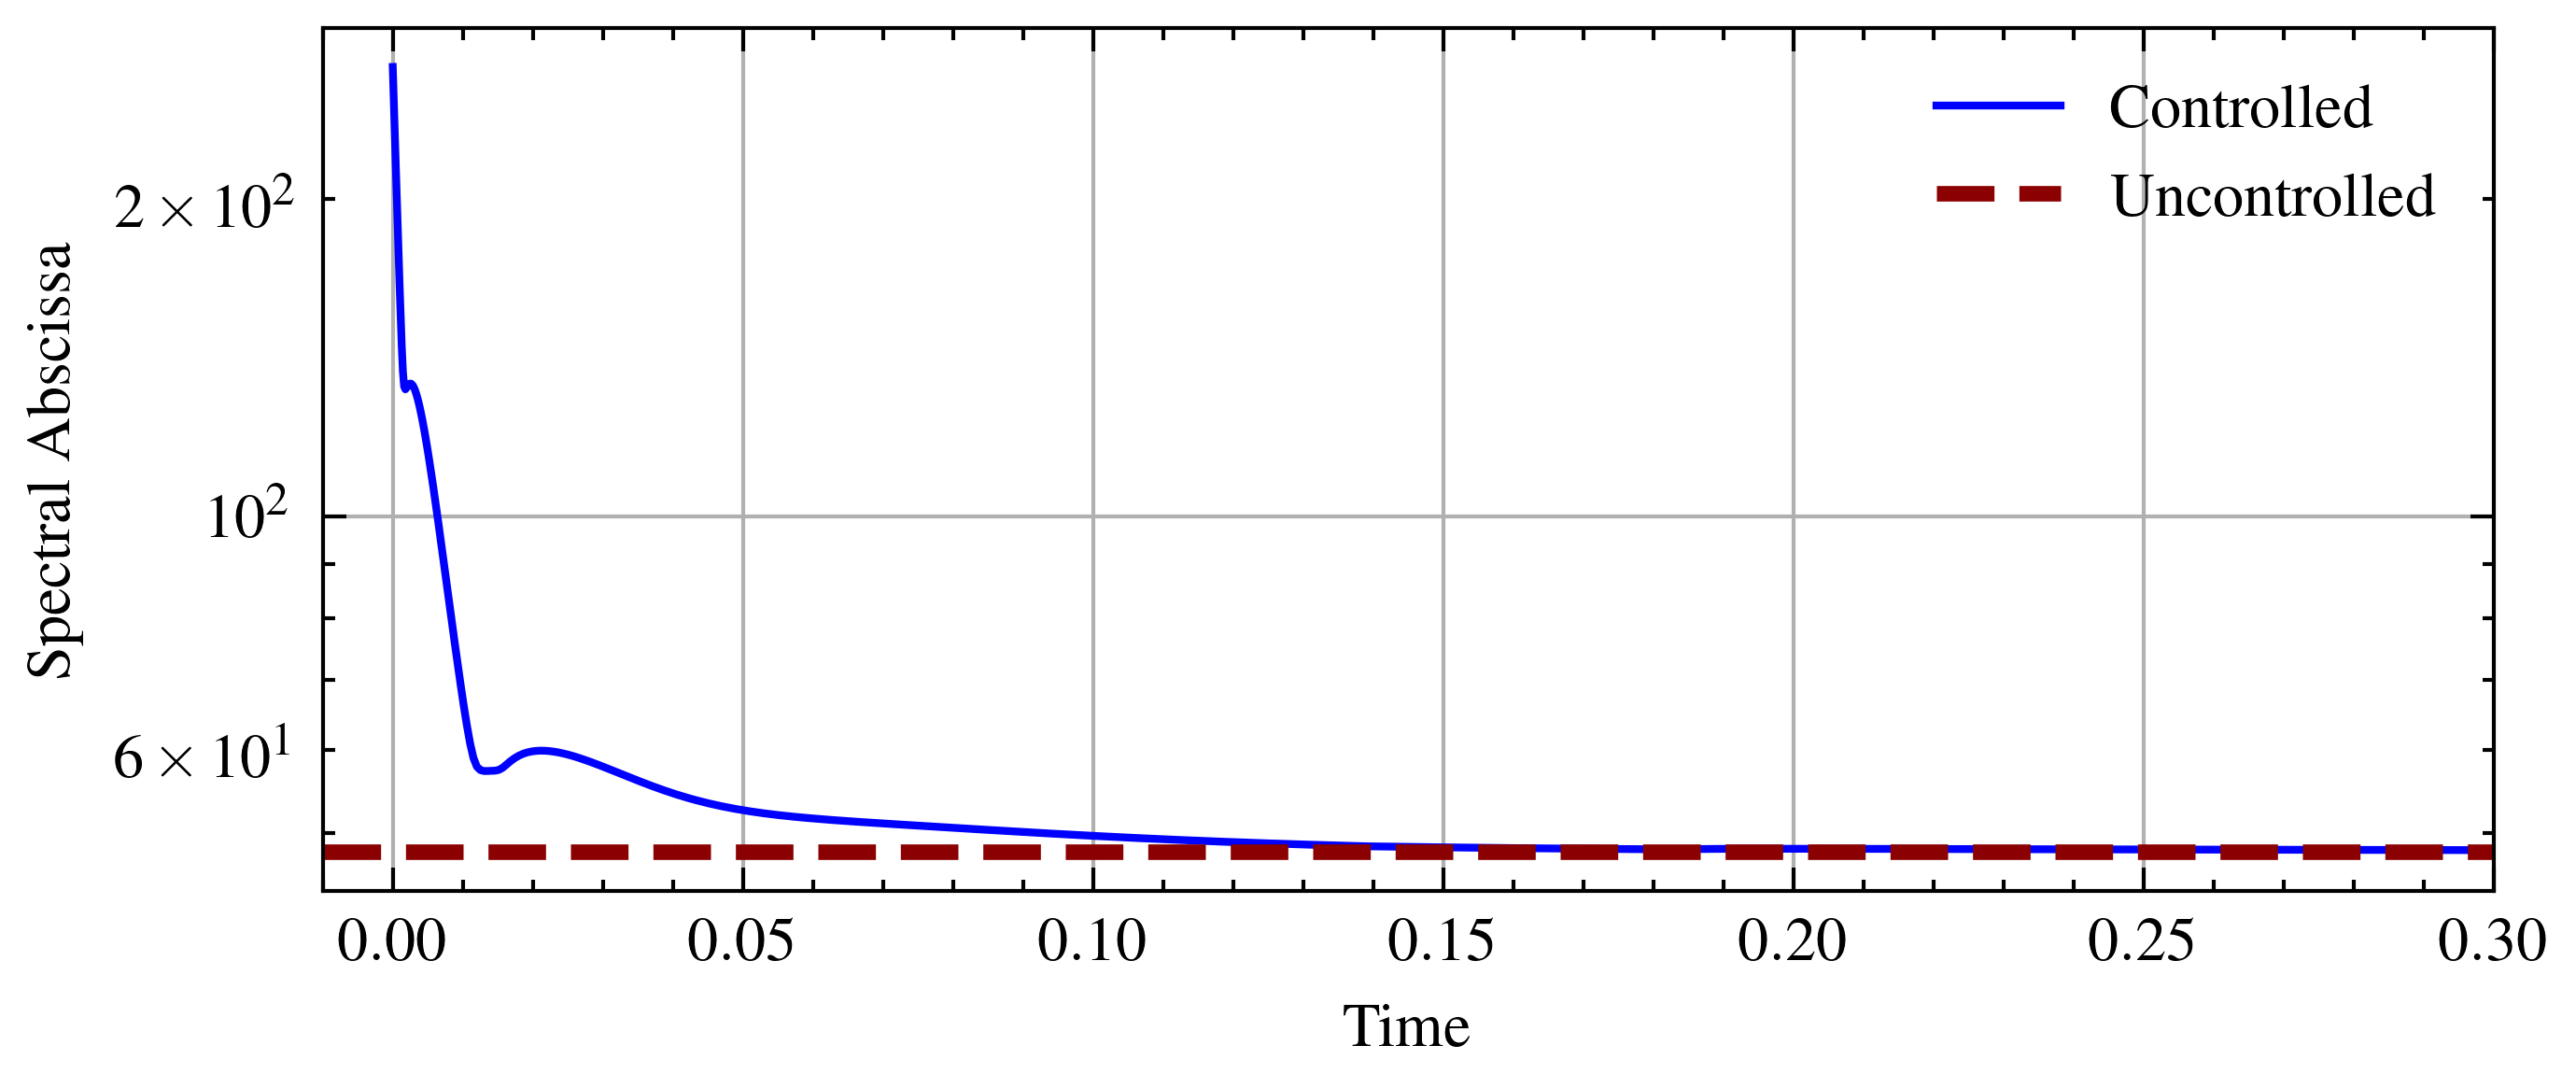

In [74]:
plt.figure(figsize=(5, 2))
#plt.plot(times, spectral_gap, 'b-', linewidth=1, label="Controlled")
plt.plot(times, spectral_abscissa, 'b-', linewidth=1, label="Controlled")
plt.axhline(solver2d.eigvals[-1], color='darkred', ls='--', lw=2, label='Uncontrolled')
plt.xlabel('Time')
#plt.ylabel('Spectral Gap')
plt.ylabel('Spectral Abscissa')
#plt.title('Time Evolution of the Spectral Gap')
plt.xlim((-0.01, 0.3))
plt.yscale('log')
plt.legend()
plt.grid(True)
#plt.savefig('../images/spectral_gap_evolution.pdf', format='pdf')
plt.savefig('../images/spectral_abscissa.pdf', format='pdf')
plt.show()

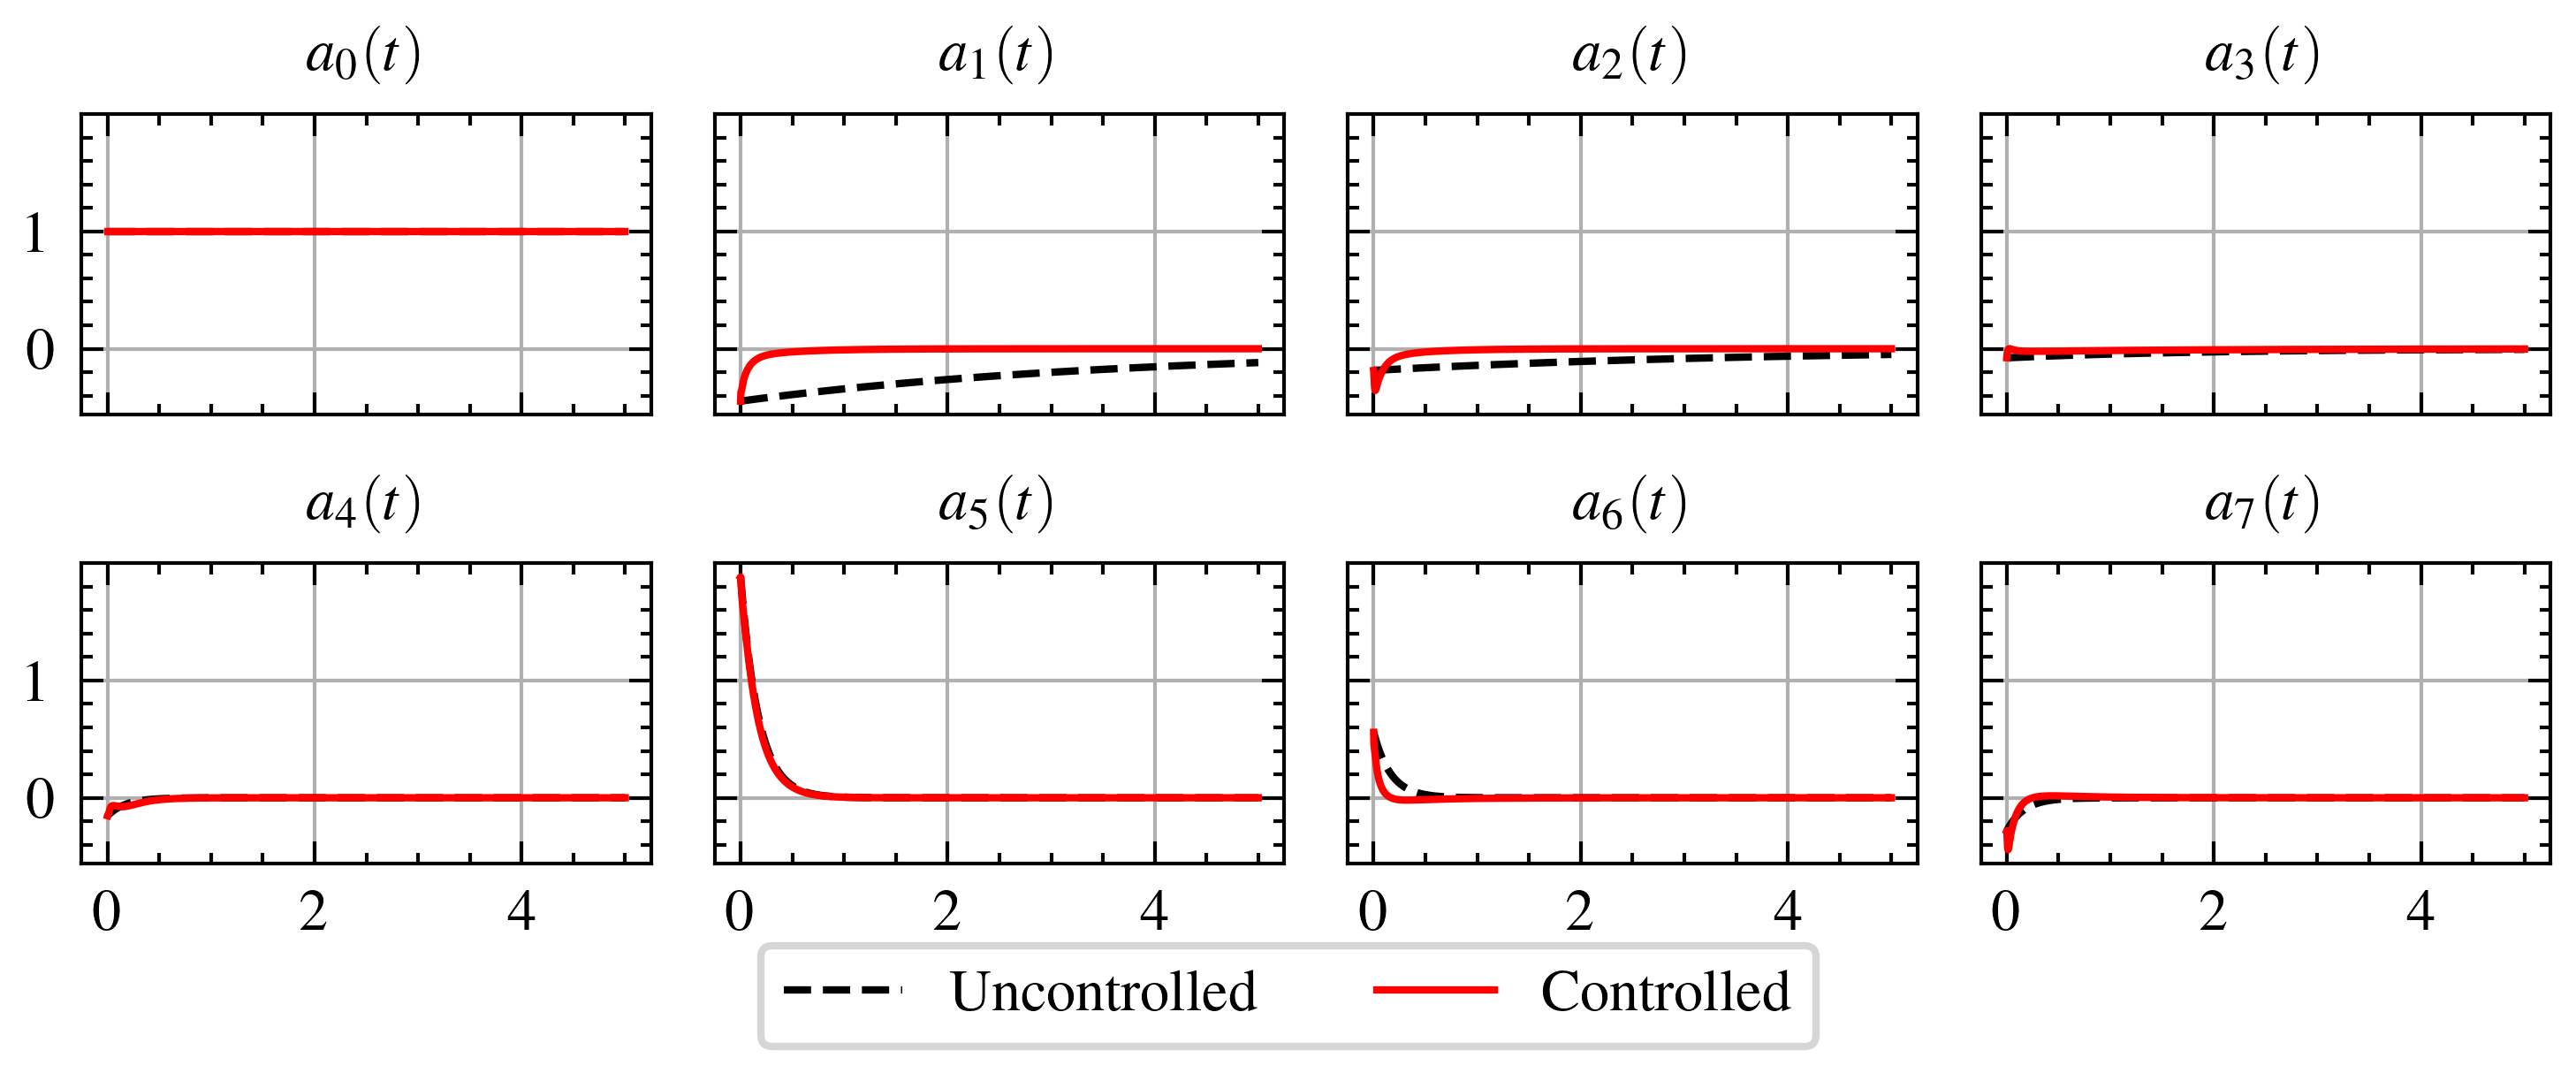

In [70]:
num_plots = 8
rows, cols = 2, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(5, 2), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result_uncontrol['time'], result_uncontrol['a_vals'][:, i], label='Uncontrolled', color='C0', ls="--")
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='-')
    ax.set_title(f'$a_{{{i}}}(t)$', fontsize=8)
    #ax.set_ylabel('Coefficient value')
    ax.grid(True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=True, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Adjust bottom to fit the legend
plt.savefig('../images/coeffs_2.pdf', format='pdf')
plt.show()